In this notebook, we want to import the boundary time data previously extracted from Oliver's TextGrid files.
We use the boundary information to get F0 points from the newly extracted F0 data (multiple PDA algorithms).
We do that with BaNa, PEFAC, and Praat AC. We also get creaky voice information to cut off points in which F0 estimations are unreliable.

We will use regression to calculate the slope of each DM unit, desconsidering creaky timeframes.

Then, we check some files visually.

Finally, we group the data by DM unit to check whether their slopiness are in line with our hypothesis.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py

In [2]:
# Import IU boundaries data
iu_boundaries = pd.read_csv('20210824_iu_boundaries.csv')

In [3]:
iu_boundaries.head()

,Unnamed: 0,file,utt,N_UT,iu,iu_start,iu_end
0,0,bpubmn01__001__LUA,1,1,AUX,0.613553,0.823710
1,1,bpubmn01__001__LUA,1,2,DCT,0.823710,1.527371
2,2,bpubmn01__001__LUA,1,3,TOP,1.527371,4.164102
3,3,bpubmn01__001__LUA,1,4,COB,5.327740,5.882946
4,4,bpubmn01__001__LUA,1,5,AUX,5.882946,6.149211


In [4]:
# Check the length of files column in iu_boundaries
len(iu_boundaries['file'].unique())

564

In [5]:
# We need to create a column that subsets the string in file column to get characters from 0 to 12

iu_boundaries['file'] = iu_boundaries['file'].str[0:13]

In [6]:
iu_boundaries.head()

,Unnamed: 0,file,utt,N_UT,iu,iu_start,iu_end
0,0,bpubmn01__001,1,1,AUX,0.613553,0.823710
1,1,bpubmn01__001,1,2,DCT,0.823710,1.527371
2,2,bpubmn01__001,1,3,TOP,1.527371,4.164102
3,3,bpubmn01__001,1,4,COB,5.327740,5.882946
4,4,bpubmn01__001,1,5,AUX,5.882946,6.149211


In [7]:
# We import the data from 20220412_results_f0.csv file
pda_results = pd.read_csv('20220412_results_f0.csv')

# We get column names
pda_results.columns

Index(['Unnamed: 0', 'timeframe', 'opensmile', 'praat_ac', 'praat_cc',
       'praat_shs', 'swipe', 'rapt', 'yin', 'pyin', 'maps', 'bana', 'pefac',
       'srh', 'straight', 'swipep', 'yaapt', 'hnr', 'cpp', 'creaky_prob',
       'creaky_decision', 'oliver', 'intensity_dB', 'se',
       'f0_derivative_oliver', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16',
       'mfcc_17', 'mfcc_18', 'mfcc_19', 'file'],
      dtype='object')

In [8]:
# We subset the strings in file column to get characters from 0 to 13
pda_results['file'] = pda_results['file'].str[0:13]

# We group by file
pda_results_grouped = pda_results.groupby('file')

# We check that we get one group correctly
pda_results_grouped.get_group('bpubmn01__001')['creaky_decision'].unique()

array([0., 1.])

In [9]:
# Now we import data.xlsx
data = pd.read_excel('data.xlsx')

In [10]:
data.head()

,id,file,utt,speaker,N_UT,T_UT,dm_text,utterance_text,tag,kept,...,f0slo,f0maxTa,f0minTa,if0sit,if0stf,N_Sil,Dur,Dm_sil,Zm_sil,Z_ut
0,df20680102,bfamdl02,68,BEL,1,2,cara,<cara> /=CNT= assim ficou simples //=COM=,CNT,OLIVER,...,-150.578,0.177,1.177,41.177,-9.447,2,198.186,99.093,-1.360,-1.931
1,cf10190103,bfamcv01,19,EVN,1,3,No',No’ /=AUX= o Galáticos é mesmo /=INT= todo mun...,EXP,TRUE,...,22.481,0.978,-0.032,6.312,3.139,1,120.230,120.230,-2.010,-2.010
2,df22150105,bfamdl02,215,BEL,1,5,não,<não /=INP= então /=DCT= já> [/1]=EMP= <basead...,CNT,OLIVER,...,-130.848,-0.148,1.000,-71.133,-79.753,1,113.023,113.023,-3.175,-3.175
3,cf10510103,bfamcv01,51,LUI,1,3,ah,ah /=AUX= <velho /=AUX_n= mas eu> gosto do Arn...,EXP,TRUE,...,61.356,0.733,0.083,23.884,17.834,1,135.725,135.725,0.083,0.083
4,cp21770102,bpubcv02,177,OSV,1,2,ô,ô /=CNT= foi o Wiliam //=COM=,CNT,OLIVER,...,-121.147,0.028,1.000,-33.155,-44.565,1,114.973,114.973,0.199,0.199


In [11]:
# Print column names
data.columns

Index(['id', 'file', 'utt', 'speaker', 'N_UT', 'T_UT', 'dm_text',
       'utterance_text', 'tag', 'kept', 'Exclusion_reason', 'stanza',
       'pattern', 'notes', 'channel', 'In', 'Insd', 'Inmax', 'Inmin', 'Intmax',
       'Intmin', 'InmaxTa', 'InminTa', 'f0', 'f0sd', 'f0max', 'f0min',
       'f0tmax', 'f0tmin', 'f0exc', 'f0slo', 'f0maxTa', 'f0minTa', 'if0sit',
       'if0stf', 'N_Sil', 'Dur', 'Dm_sil', 'Zm_sil', 'Z_ut'],
      dtype='object')

In [12]:
# We need to create a column for the file name in the data dataframe
# We will use file and utt columns to create the file name
# This should be in the file__utt format in which utt must have 3 digits

# Create a function to create file name
def create_file_name(row):
    """
    This function creates a file name from file and utt columns
    """
    # Convert utt to string
    utt = str(row['utt'])
    # Check the length of utt
    if len(utt) == 1:
        utt = '00' + utt
    elif len(utt) == 2:
        utt = '0' + utt
    # Create file name
    file_name = row['file'] + '__' + utt
    return file_name

# Create a new column for file name
data['file_name'] = data.apply(create_file_name, axis=1)

# Check the data
data.head()

,id,file,utt,speaker,N_UT,T_UT,dm_text,utterance_text,tag,kept,...,f0maxTa,f0minTa,if0sit,if0stf,N_Sil,Dur,Dm_sil,Zm_sil,Z_ut,file_name
0,df20680102,bfamdl02,68,BEL,1,2,cara,<cara> /=CNT= assim ficou simples //=COM=,CNT,OLIVER,...,0.177,1.177,41.177,-9.447,2,198.186,99.093,-1.360,-1.931,bfamdl02__068
1,cf10190103,bfamcv01,19,EVN,1,3,No',No’ /=AUX= o Galáticos é mesmo /=INT= todo mun...,EXP,TRUE,...,0.978,-0.032,6.312,3.139,1,120.230,120.230,-2.010,-2.010,bfamcv01__019
2,df22150105,bfamdl02,215,BEL,1,5,não,<não /=INP= então /=DCT= já> [/1]=EMP= <basead...,CNT,OLIVER,...,-0.148,1.000,-71.133,-79.753,1,113.023,113.023,-3.175,-3.175,bfamdl02__215
3,cf10510103,bfamcv01,51,LUI,1,3,ah,ah /=AUX= <velho /=AUX_n= mas eu> gosto do Arn...,EXP,TRUE,...,0.733,0.083,23.884,17.834,1,135.725,135.725,0.083,0.083,bfamcv01__051
4,cp21770102,bpubcv02,177,OSV,1,2,ô,ô /=CNT= foi o Wiliam //=COM=,CNT,OLIVER,...,0.028,1.000,-33.155,-44.565,1,114.973,114.973,0.199,0.199,bpubcv02__177


In [13]:
# Import statsmodels
import statsmodels.api as sm

# Create a function to fit a line to the data and output coefficients of slope and intercept
# This function should consider that y data can have NaN values
# Besisdes, it takes a z vector containing 1 and 0 values. All the frames that have 1 values in z vector should be transformed to NaN values in y vector
# The function 

def fit_line(x, y, z):
    """
    This function fits a line to the data and outputs coefficients of slope and intercept
    """
    # Create a dataframe from x, y, and z vectors
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    # Transform all the frames that have 1 values in z vector to NaN values in y vector
    df['y'] = df['y'].where(df['z'] == 0, np.nan)
    # Drop NaN values
    df = df.dropna()
    # Fit a line to the data
    model = sm.OLS(df['y'], sm.add_constant(df['x']))
    results = model.fit()
    # Get slope and intercept
    slope = results.params[1]
    intercept = results.params[0]
    # Return slope and intercept
    return slope, intercept


"""
Procurar como fazer uma regressão linear robusta

Colocar pesos com base na informção de intensidade
Os pontos de intensidade mais baixa têm menos peso de um ponto de perceptivo
Uma regressão linear robusta que leve em consideração pesos de intensidade

"""

'\nProcurar como fazer uma regressão linear robusta\n\nColocar pesos com base na informção de intensidade\nOs pontos de intensidade mais baixa têm menos peso de um ponto de perceptivo\nUma regressão linear robusta que leve em consideração pesos de intensidade\n\n'

In [14]:
# Import statsmodels
import statsmodels.api as sm

# Create a function to fit a line to the data and output coefficients of slope and intercept
# This function should consider that y data can have NaN values
# Besisdes, it takes a z vector containing 1 and 0 values. All the frames that have 1 values in z vector should be transformed to NaN values in y vector
# This function receives a w vector that contains weights for each frame

def fit_line_weighted(x, y, z, w):
    """
    This function fits a line to the data and outputs coefficients of slope and intercept
    """
    
    # Inverse of intensity as weights
    w = 1 / w
    # Create a dataframe from x, y, and z vectors
    df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'w': w})
    # Transform all the frames that have 1 values in z vector to NaN values in y vector
    df['y'] = df['y'].where(df['z'] == 0, np.nan)
    # Drop NaN values
    df = df.dropna()
    # Fit a line to the data
    model = sm.WLS(df['y'], sm.add_constant(df['x']), weights=df['w'])
    results = model.fit()
    # Get slope and intercept
    slope = results.params[1]
    intercept = results.params[0]
    # Return slope and intercept
    return slope, intercept


"""
Procurar como fazer uma regressão linear robusta

Colocar pesos com base na informção de intensidade
Os pontos de intensidade mais baixa têm menos peso de um ponto de perceptivo
Uma regressão linear robusta que leve em consideração pesos de intensidade

"""

'\nProcurar como fazer uma regressão linear robusta\n\nColocar pesos com base na informção de intensidade\nOs pontos de intensidade mais baixa têm menos peso de um ponto de perceptivo\nUma regressão linear robusta que leve em consideração pesos de intensidade\n\n'

In [15]:
# We do fit_line with sklearn RANSACRegressor
from sklearn.linear_model import RANSACRegressor

def fit_line_ransac(x, y, z):
    """
    This function fits a line to the data and outputs coefficients of slope and intercept
    """
    # Create a dataframe from x, y, and z vectors
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    # Transform all the frames that have 1 values in z vector to NaN values in y vector
    df['y'] = df['y'].where(df['z'] == 0, np.nan)
    # Drop NaN values
    df = df.dropna()
    # Fit a line to the data
    model = RANSACRegressor(random_state=0).fit(df['x'].values.reshape(-1, 1), df['y'].values.reshape(-1, 1))
    # Get slope and intercept
    slope = model.estimator_.coef_[0][0]
    intercept = model.estimator_.intercept_[0]
    # Return slope and intercept
    return slope, intercept

In [191]:
# We do fit_line with sklearn RANSACRegressor
from sklearn.linear_model import RANSACRegressor

def fit_line_ransac_weighted(x, y, z, w):
    """
    This function fits a line to the data and outputs coefficients of slope and intercept
    """
    # Create a dataframe from x, y, and z vectors
    df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'w': w})

    # We drop rows where z == 1
    df = df[df['z'] == 0]
    df = df.dropna()

    # Fit a line to the data
    model = RANSACRegressor(random_state=0).fit(df['x'].values.reshape(-1, 1), df['y'].values.reshape(-1, 1), sample_weight=df['w'].values)
    # Get slope and intercept
    slope = model.estimator_.coef_[0][0]
    intercept = model.estimator_.intercept_[0]
    # Return slope and intercept
    return slope, intercept

In [212]:
# We need to create a pipeline
# iterate through all the rows in data dataframe
# for each row, get the file_name and N_UT
# Then we search for the filename and N_UT in the iu_boundaries dataframe
# We get the iu_start and iu_end values
# Finally, we go to the h5py_file, search for the corresponding file_name, and get all the rows between iu_start and iu_end, considering the time column that increases by 10ms

# Create a function to get the data from h5py file
def get_data_from_h5py(row):
    """
    This function gets the data from h5py file
    """
    # Get the file_name and N_UT
    file_name = row['file_name']
    N_UT = row['N_UT']
    # Search for the file_name and N_UT in iu_boundaries dataframe
    iu_boundaries_subset = iu_boundaries[(iu_boundaries['file'] == file_name) & (iu_boundaries['N_UT'] == N_UT)]
    # Get the iu_start and iu_end values
    iu_start = iu_boundaries_subset['iu_start'].values[0]
    iu_end = iu_boundaries_subset['iu_end'].values[0]
    # Go to the h5py_file, search for the corresponding file_name, and get all data
    data_subset = pda_results_grouped.get_group(file_name)

    # Get the data between iu_start and iu_end in the timeframe column of data_subset
    data_subset = data_subset[(data_subset['timeframe'] >= iu_start) & (data_subset['timeframe'] <= iu_end)]
    # Return data_subset
    return data_subset

# Create a new dataframe to store the data
data_subset = pd.DataFrame()

subset_dict = {}

# Iterate through all the rows in data dataframe
for index, row in data.iterrows():
    try:
        # Get the data from h5py file
        data_subset_temp = get_data_from_h5py(row)

        # Append data_subset_temp to data_subset using file_name as key
        subset_dict[row['file_name']] = data_subset_temp

        # We calculate the slope and intercept for 5 different algorithms
        # We create a list of algorithms
        algorithms = ['bana', 'pefac', 'praat_ac', 'pyin', 'srh']
        z = data_subset_temp['creaky_decision'].values
        x = data_subset_temp['timeframe'].values
        w = data_subset_temp['intensity_dB'].values

        mean_se = np.mean(w)
        data.loc[index, 'mean_se'] = mean_se

        for algorithm in algorithms:
            try:
                y = data_subset_temp[algorithm].values
                slope, intercept = fit_line_ransac_weighted(x, y, z, w)
                # We create a new column for the slope and intercept in the data dataframe
                data.loc[index, algorithm + '_slope'] = slope
                data.loc[index, algorithm + '_intercept'] = intercept
            except Exception as e:
                print("Algorithm {0} not performed because of {1}".format(algorithm, e))
                slope, intercept = np.nan, np.nan
                # We create a new column for the slope and intercept in the data dataframe
                data.loc[index, algorithm + '_slope'] = slope
                data.loc[index, algorithm + '_intercept'] = intercept
        
    except Exception as e:
        print("File {0} not performed because of {1}".format(row['file_name'], e))



Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm praat_ac not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of `min_samples` may not be larger than number of samples: n_samples = 1.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 

/Users/saulosantos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Algorithm pyin not performed because of `min_samples` may not be larger than number of samples: n_samples = 1.


/Users/saulosantos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/saulosantos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/saulosantos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/saulosantos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/saulosantos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: Undefin

Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of `min_samples` may not be larger than number of samples: n_samples = 1.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 samp

/Users/saulosantos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pyin not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm bana not performed because of Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Algorithm pefac not performed because of Found array wit

In [195]:
# We save the data_subset dictionary as a pickle file
import pickle

with open('DM_data_points.pickle', 'wb') as handle:
    pickle.dump(subset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [213]:
data.head()

,id,file,utt,speaker,N_UT,T_UT,dm_text,utterance_text,tag,kept,...,bana_slope,bana_intercept,pefac_slope,pefac_intercept,praat_ac_slope,praat_ac_intercept,pyin_slope,pyin_intercept,srh_slope,srh_intercept
0,df20680102,bfamdl02,68,BEL,1,2,cara,<cara> /=CNT= assim ficou simples //=COM=,CNT,OLIVER,...,-266.305866,486.606548,4582.233450,-1683.244639,169.809857,310.942689,-468.940797,589.378169,-477.481892,571.996459
1,cf10190103,bfamcv01,19,EVN,1,3,No',No’ /=AUX= o Galáticos é mesmo /=INT= todo mun...,EXP,TRUE,...,103.160049,82.404273,95.947518,85.754888,141.343113,64.128300,100.131812,81.901265,106.089208,84.076396
2,df22150105,bfamdl02,215,BEL,1,5,não,<não /=INP= então /=DCT= já> [/1]=EMP= <basead...,CNT,OLIVER,...,-2020.369935,1081.405476,-2233.944390,1208.451125,-2419.540344,1289.263613,NaN,NaN,-1109.313170,693.095434
3,cf10510103,bfamcv01,51,LUI,1,3,ah,ah /=AUX= <velho /=AUX_n= mas eu> gosto do Arn...,EXP,TRUE,...,522.727208,-115.530553,394.491920,-52.750696,398.590746,-57.209330,0.000000,183.667135,425.582771,-57.612234
4,cp21770102,bpubcv02,177,OSV,1,2,ô,ô /=CNT= foi o Wiliam //=COM=,CNT,OLIVER,...,-1075.219828,765.465276,1380.178215,-547.067828,-1107.896820,795.490715,NaN,NaN,-970.010034,709.720819


In [214]:
# We save data to a xlsx file for further analysis
data.to_excel('data_with_slopes_weighted-intensity.xlsx', index=False)

In [215]:
# We read the data from xlsx file
# data = pd.read_excel('data_with_slopes_weighted.xlsx')

# PLOT SLOPE AND COEFFICIENTS DATA

In [216]:
# First we need to subset the data dataframe to get only rows that are in initial ('i') position in the pattern column
initial = data[data['pattern'] == 'i']

In [217]:
# We subset initial to get only rows in which column tag is equal to CNT, INP, FLAT and EXP
initial = initial[initial['tag'].isin(['CNT', 'INP', 'FLAT', 'EXP'])]

# Then we remap the column tag so that INP and FLAT are mapped to INP
initial['tag'] = initial['tag'].map({'CNT': 'CNT', 'INP': 'INP', 'FLAT': 'INP', 'EXP': 'EXP'})

In [218]:
initial.shape

(133, 52)

In [219]:
initial.columns

Index(['id', 'file', 'utt', 'speaker', 'N_UT', 'T_UT', 'dm_text',
       'utterance_text', 'tag', 'kept', 'Exclusion_reason', 'stanza',
       'pattern', 'notes', 'channel', 'In', 'Insd', 'Inmax', 'Inmin', 'Intmax',
       'Intmin', 'InmaxTa', 'InminTa', 'f0', 'f0sd', 'f0max', 'f0min',
       'f0tmax', 'f0tmin', 'f0exc', 'f0slo', 'f0maxTa', 'f0minTa', 'if0sit',
       'if0stf', 'N_Sil', 'Dur', 'Dm_sil', 'Zm_sil', 'Z_ut', 'file_name',
       'mean_se', 'bana_slope', 'bana_intercept', 'pefac_slope',
       'pefac_intercept', 'praat_ac_slope', 'praat_ac_intercept', 'pyin_slope',
       'pyin_intercept', 'srh_slope', 'srh_intercept'],
      dtype='object')

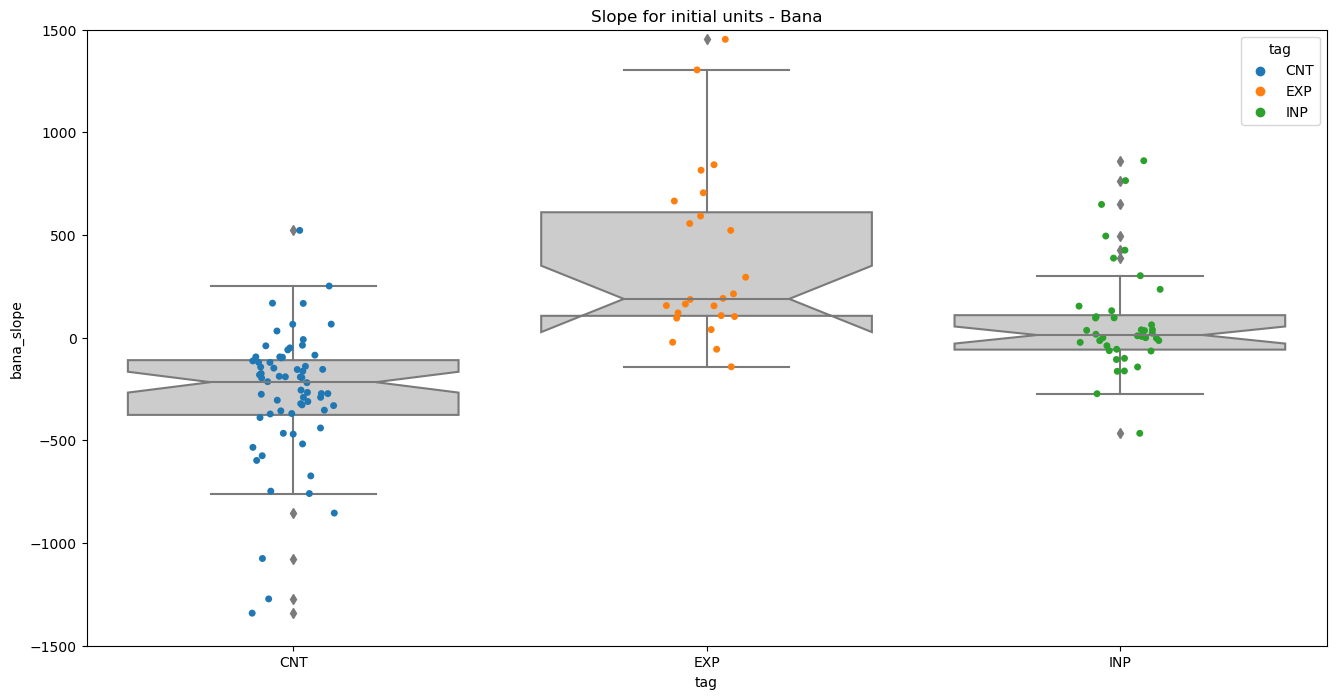

In [221]:
# Bana slope

# Set figure size
plt.figure(figsize=(16, 8))

# Set ylim
plt.ylim(-1500, 1500)
sns.boxplot(x='tag', y='bana_slope', data=initial, color='0.8', notch=True, zorder=1)
sns.stripplot(x='tag', y='bana_slope', data=initial, hue='tag', jitter=True, zorder=1)
# Set title
plt.title('Slope for initial units - Bana')
plt.show()

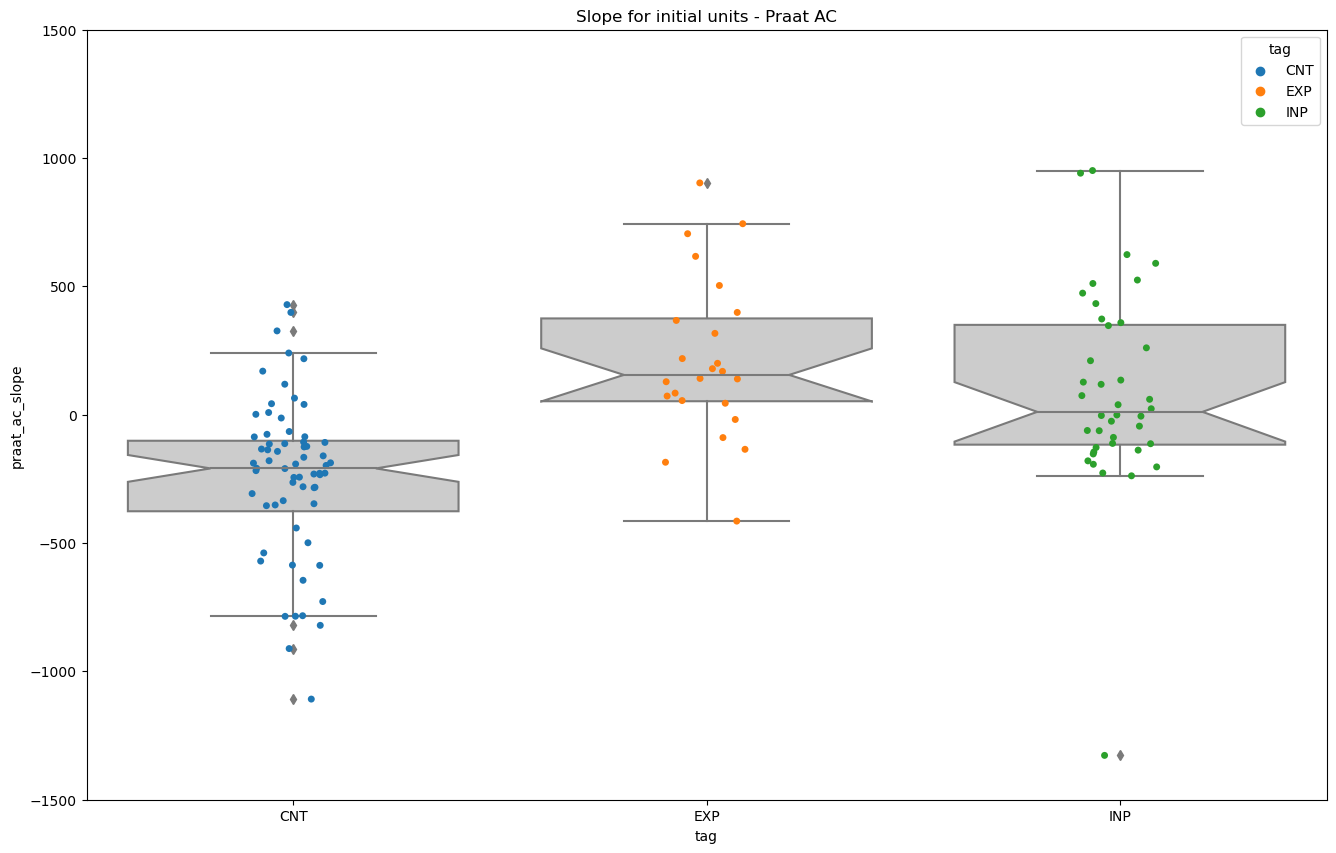

In [222]:
# We plot the slope and intercept for all units
# We use now praat_ac_slope and praat_ac_intercept

# Set figure size
plt.figure(figsize=(16, 10))

# Set ylim
plt.ylim(-1500, 1500)

sns.boxplot(x='tag', y='praat_ac_slope', data=initial, color='0.8', notch=True, zorder=1)
sns.stripplot(x='tag', y='praat_ac_slope', data=initial, hue='tag', jitter=True, zorder=1)

# Set title
plt.title('Slope for initial units - Praat AC')
plt.show()

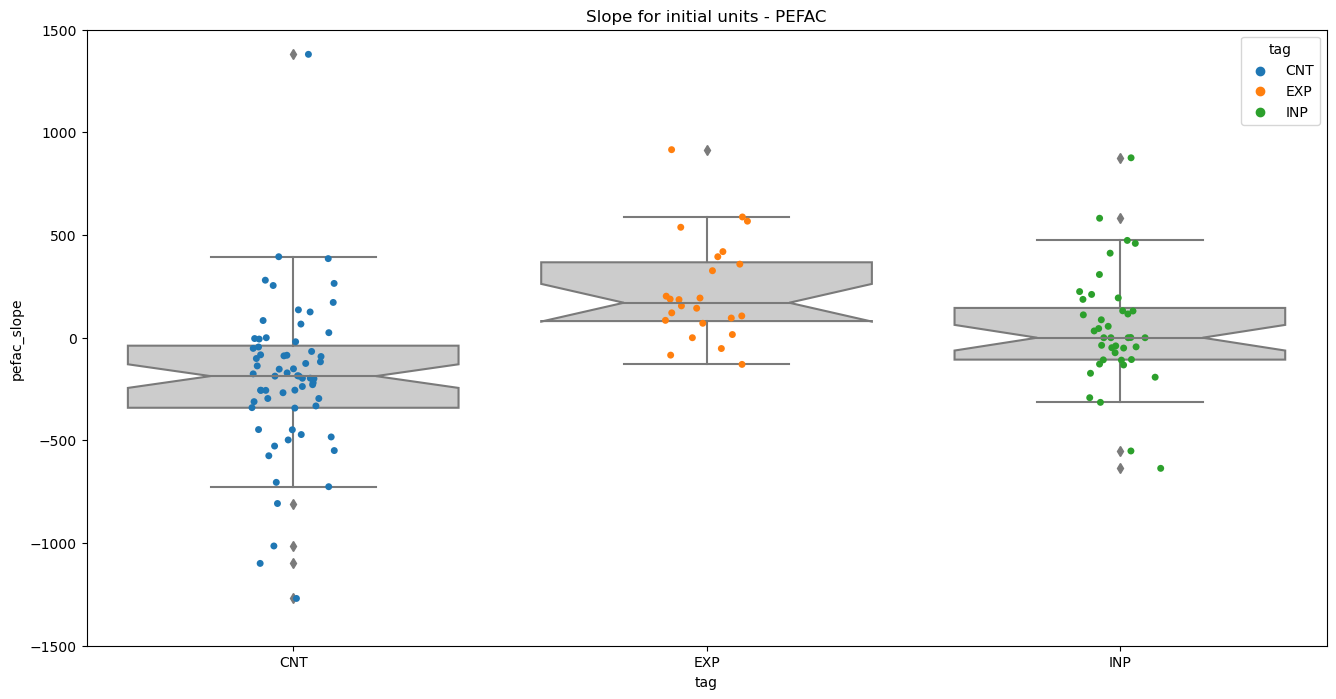

In [224]:
# The same for PEFAC

# Set figure size
plt.figure(figsize=(16, 8))

# Set ylim
plt.ylim(-1500, 1500)

sns.boxplot(x='tag', y='pefac_slope', data=initial, color='0.8', notch=True, zorder=1)
sns.stripplot(x='tag', y='pefac_slope', data=initial, hue='tag', jitter=True, zorder=1)

# Set title
plt.title('Slope for initial units - PEFAC')
plt.show()

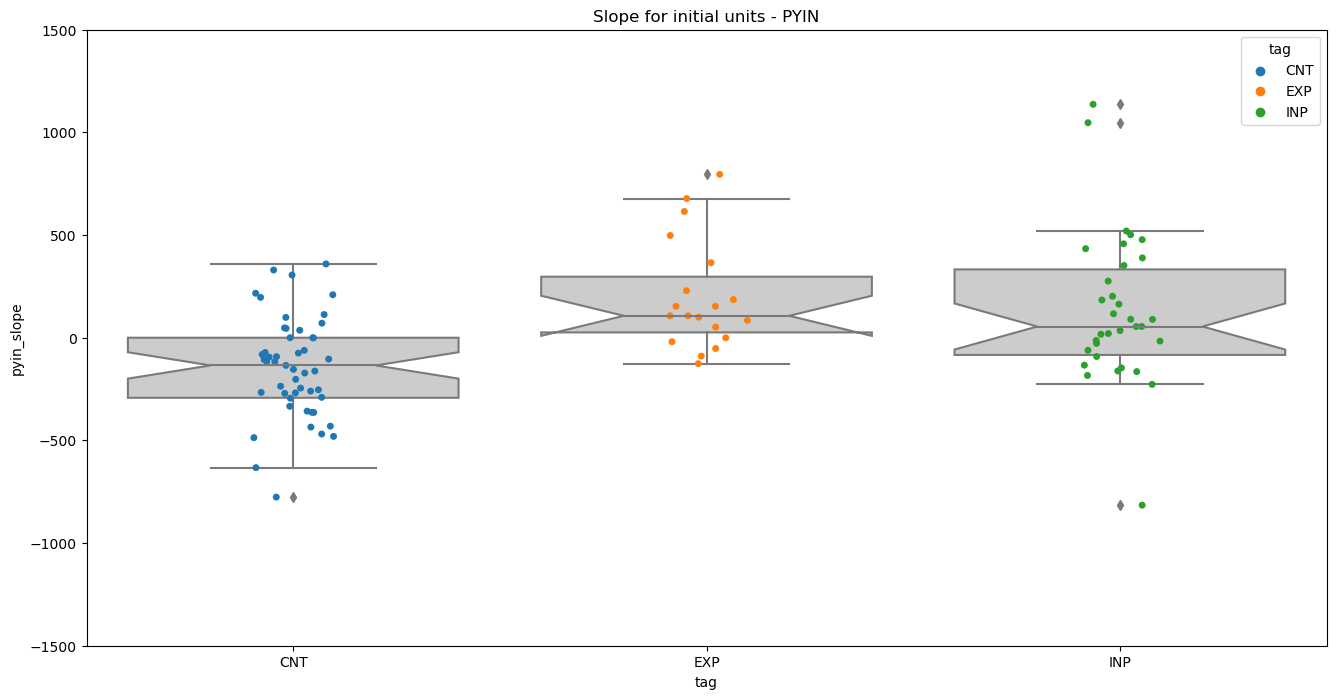

In [225]:
# The same for PYIN

# Set figure size
plt.figure(figsize=(16, 8))

# Set ylim
plt.ylim(-1500, 1500)

sns.boxplot(x='tag', y='pyin_slope', data=initial, color='0.8', notch=True, zorder=1)
sns.stripplot(x='tag', y='pyin_slope', data=initial, hue='tag', jitter=True, zorder=1)

# Set title
plt.title('Slope for initial units - PYIN')
plt.show()

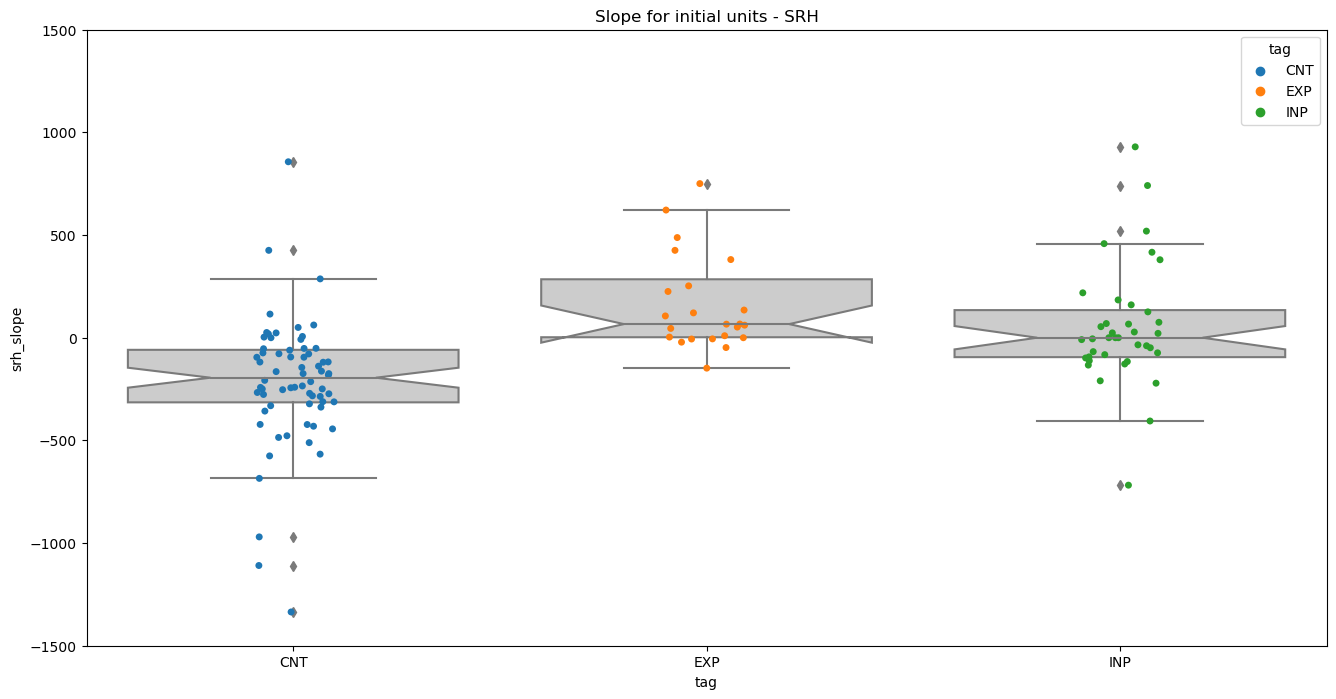

In [226]:
# Same for SRH

# Set figure size
plt.figure(figsize=(16, 8))

# Set ylim
plt.ylim(-1500, 1500)

sns.boxplot(x='tag', y='srh_slope', data=initial, color='0.8', notch=True, zorder=1)
sns.stripplot(x='tag', y='srh_slope', data=initial, hue='tag', jitter=True, zorder=1)

# Set title
plt.title('Slope for initial units - SRH')
plt.show()


In [227]:
# We want to check the curves of some outliers
# We will check the curves of the INP units that have a slope greater than 0.005 and lower than -0.005 in PEFAC

# We subset the data
initial_outliers = initial[(initial['tag'] == 'INP') & ((initial['srh_slope'] > 200) | (initial['pefac_slope'] < -200))]
initial_outliers.shape

(11, 52)

In [228]:
# List file names
initial_outliers['file_name'].unique()

array(['bfamcv02__063', 'bfamcv02__096', 'bfamcv02__317', 'bfamcv03__045',
       'bfamdl01__407', 'bfamdl02__152', 'bfamdl02__209', 'bfamdl02__218',
       'bfamdl03__206', 'bfamdl03__225', 'bpubcv01__001'], dtype=object)

In [229]:
# We get a random file_name and N_UT from initial_outliers

# Get file_name from initial_outliers keys and choose one randomly
# file_random = np.random.choice(list(initial_outliers['file_name'].unique()))

file_random = 'bfamdl01__260'

# We get the data from subset_dict
data_subset_temp = subset_dict[file_random]

# Creaky decision must be plot in two different colors depending on the value: red if it is 1 and blue if it is 0
#data_subset_temp['creaky_decision'] = data_subset_temp['creaky_decision'].map({0: 'blue', 1: 'red'})

In [230]:
data_subset_temp.columns

Index(['Unnamed: 0', 'timeframe', 'opensmile', 'praat_ac', 'praat_cc',
       'praat_shs', 'swipe', 'rapt', 'yin', 'pyin', 'maps', 'bana', 'pefac',
       'srh', 'straight', 'swipep', 'yaapt', 'hnr', 'cpp', 'creaky_prob',
       'creaky_decision', 'oliver', 'intensity_dB', 'se',
       'f0_derivative_oliver', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16',
       'mfcc_17', 'mfcc_18', 'mfcc_19', 'file'],
      dtype='object')

In [231]:
data_subset_temp['creaky_decision'].unique()

array([1., 0.])

# NOTES
We have to document how we are

- Modèle de sonies (intensité en sones) - production
- Modèle de loudness - perception

- HNR 

- Correlation entre les mesures


# TODO:
 1. Look for the indicators that part of the curve is not good
 2. HNR / Creaky / Modèles de sonies et Loudness / Intensité / SE / Cepstral peak prominences

Analyse de discriminant pour voir comment les facteurs arrive à prendre les bonnes parties des courbes


FAzer uma rotina de classificação que teste as regressões e veja que tipo de ponderação dá os melhores resultados.

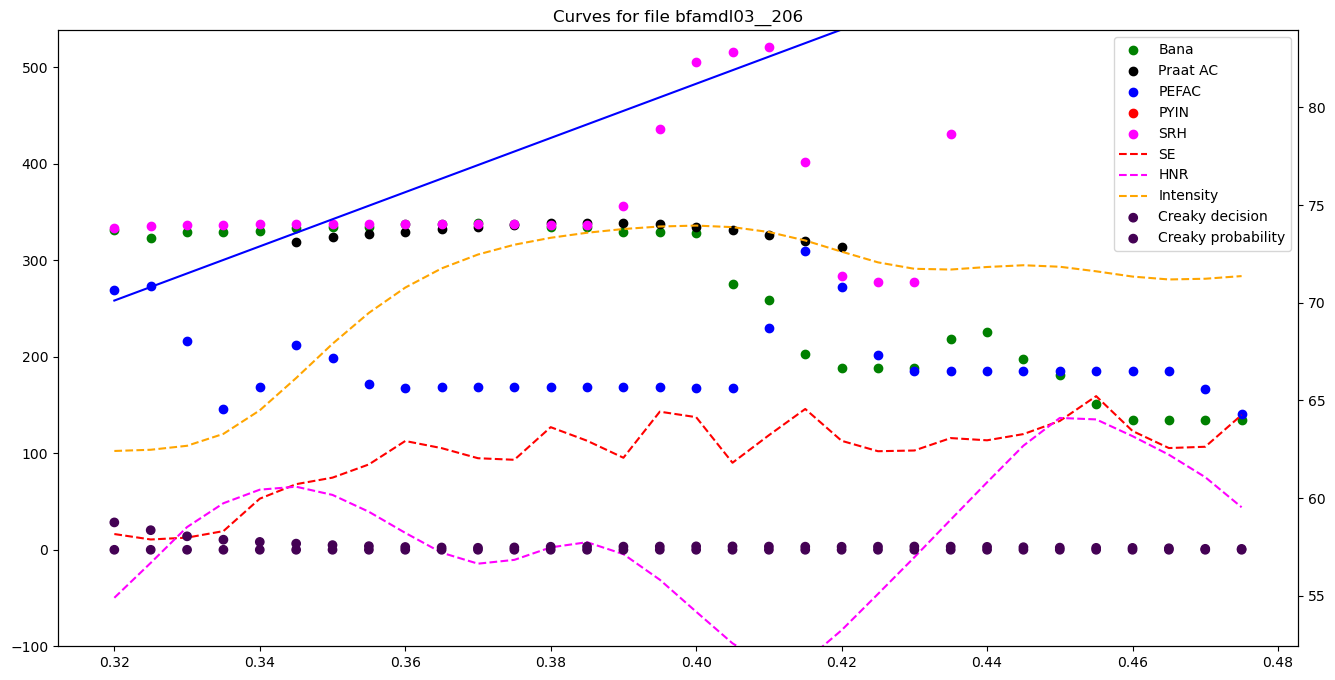

In [237]:
# We plot intensity and se curves at the same plot with different colours

FILE = 'bfamdl03__206'
ALGO = 'srh'

# We get the data from subset_dict
data_subset_temp = subset_dict[FILE]

# We plot the curve
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

# Set y-axis limits for ax1
ax1_left_ylim = max(data_subset_temp['bana']) + 200
# If nan, then set to 500
if np.isnan(ax1_left_ylim):
    ax1_left_ylim = 500
ax1.set_ylim(-100, ax1_left_ylim)

# Set y-axis limits for ax2
intensity_min = min(data_subset_temp['intensity_dB'])
intensity_max = max(data_subset_temp['intensity_dB'])
ax2_right_ylim_min = intensity_min - 10
ax2_right_ylim_max = intensity_max + 10
ax2.set_ylim(ax2_right_ylim_min, ax2_right_ylim_max)

# We must use two different y axis and limits: one for pefac and other for intensity and se
#ax1 = plt.gca()
#ax2 = ax1.twinx()

# Plot the dashed curves
# Plot the dashed curves
bana_plot = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['bana'], color='green', zorder=1)
praat_ac_plot = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['praat_ac'], color='black', zorder=1)
pefac_plot = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['pefac'], color='blue', zorder=1)
pyin_plot = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['pyin'], color='red', zorder=1)
srh_plot = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['srh'], color='fuchsia', zorder=1)

# Plot the dashed curves
se_plot = ax1.plot(data_subset_temp['timeframe'], data_subset_temp['se']*10, color='red', zorder=1, linestyle='dashed')
hnr_plot = ax1.plot(data_subset_temp['timeframe'], data_subset_temp['hnr']*10, color='fuchsia', zorder=1, linestyle='dashed')
intensity_plot = ax2.plot(data_subset_temp['timeframe'], data_subset_temp['intensity_dB'], color='orange', zorder=1, linestyle='dashed')

# We want to plot the regression line
slope = data[data['file_name'] == FILE][ALGO + '_slope'].values[0]
intercept = data[data['file_name'] == FILE][ALGO + '_intercept'].values[0]
abline_values = [slope * i + intercept for i in data_subset_temp['timeframe'].values]
ax1.plot(data_subset_temp['timeframe'].values, abline_values, color='blue', zorder=1)

# Plot creaky decision
creaky_decision_plot = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['creaky_decision'], c=data_subset_temp['creaky_decision'], zorder=1)

# Plot the creaky probability * 100 with colours mapped to creaky decision
creaky_prob = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['creaky_prob']*100, c=data_subset_temp['creaky_decision'], zorder=1)


# Set legends
ax1.legend([bana_plot, praat_ac_plot, pefac_plot, pyin_plot, srh_plot, se_plot[0], hnr_plot[0], intensity_plot[0], creaky_decision_plot, creaky_prob], ['Bana', 'Praat AC', 'PEFAC', 'PYIN', 'SRH', 'SE', 'HNR', 'Intensity', 'Creaky decision', 'Creaky probability'], loc='upper right')
#ax1.legend(algo_plot + se_plot + hnr_plot, [ALGO.capitalize(), 'SE', 'HNR', 'Regression line'], loc='upper right')
#ax2.legend(intensity_plot + [creaky_decision_plot], ['Intensity', 'Creaky decision', 'Creaky probability'], loc='upper left')



# Set title
plt.title('Curves for file {0}'.format(FILE))
plt.show()


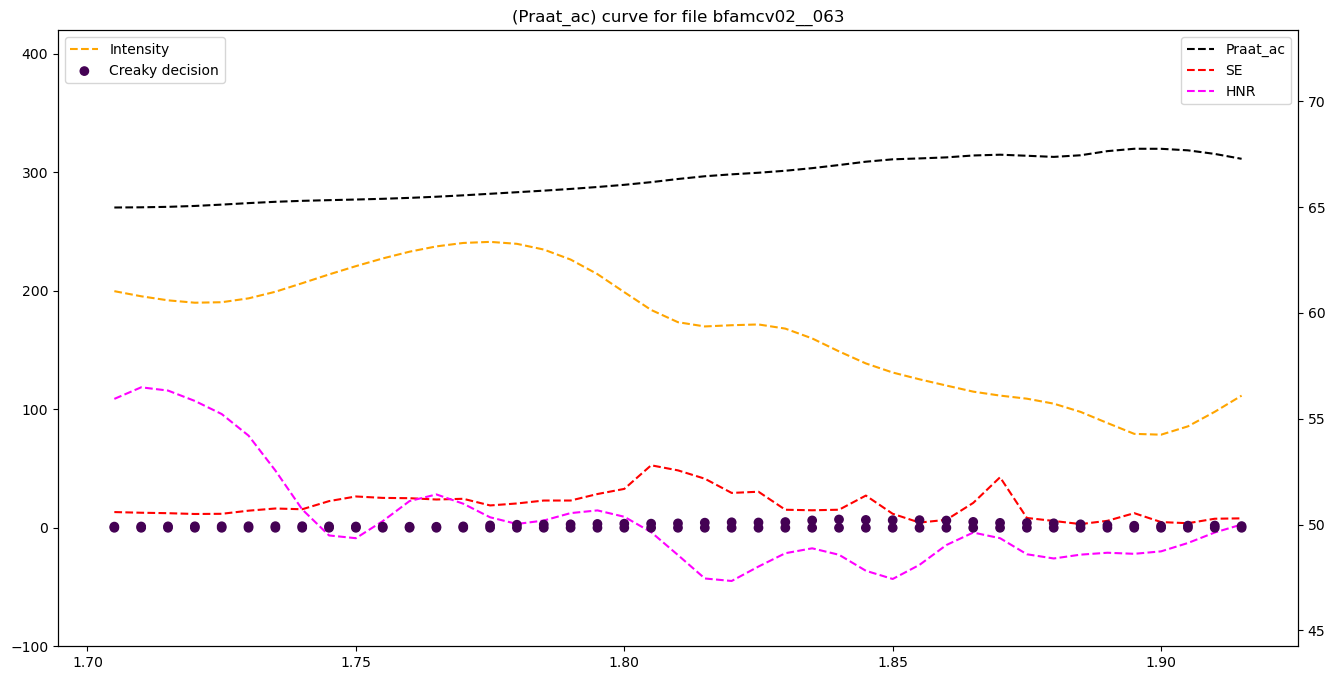

<Figure size 640x480 with 0 Axes>

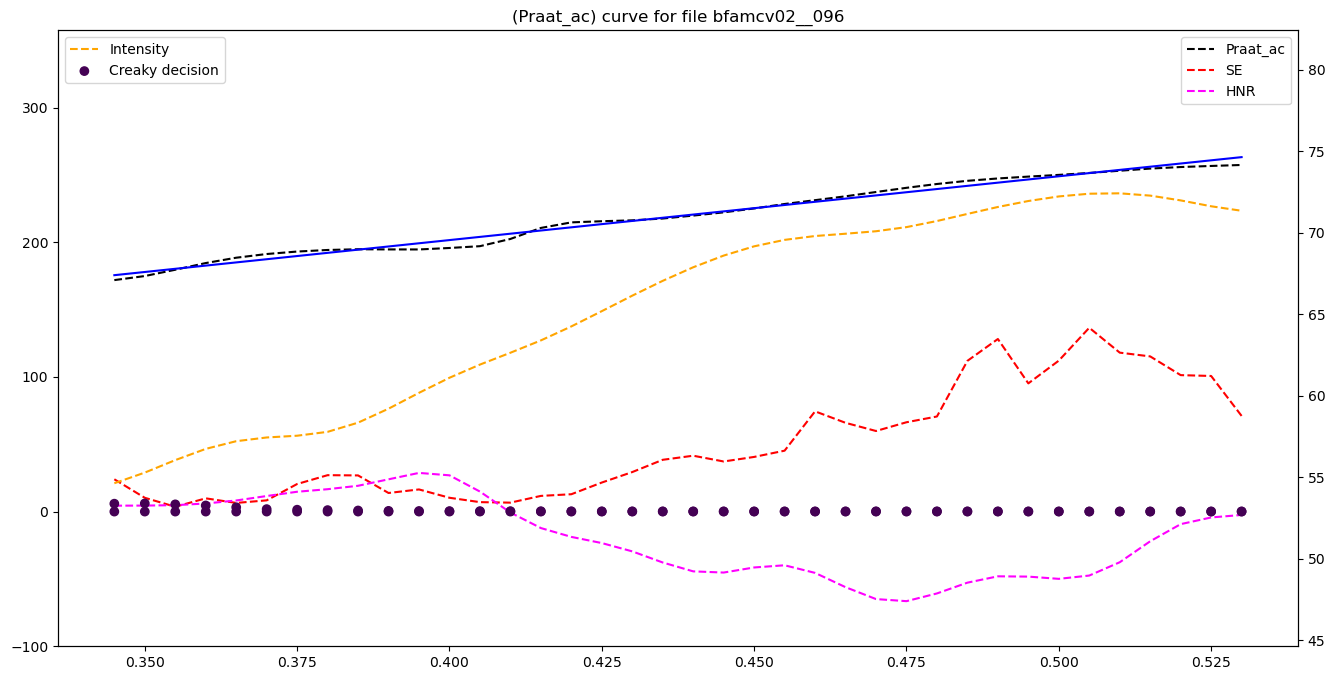

<Figure size 640x480 with 0 Axes>

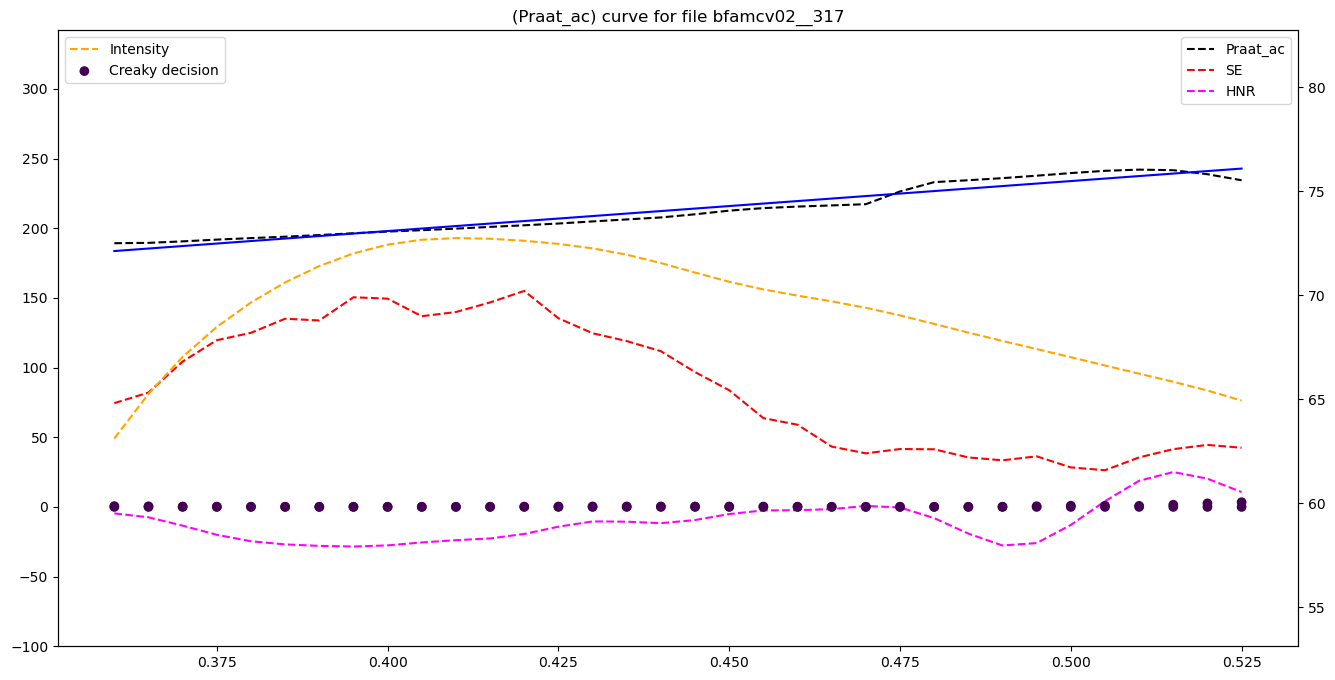

<Figure size 640x480 with 0 Axes>

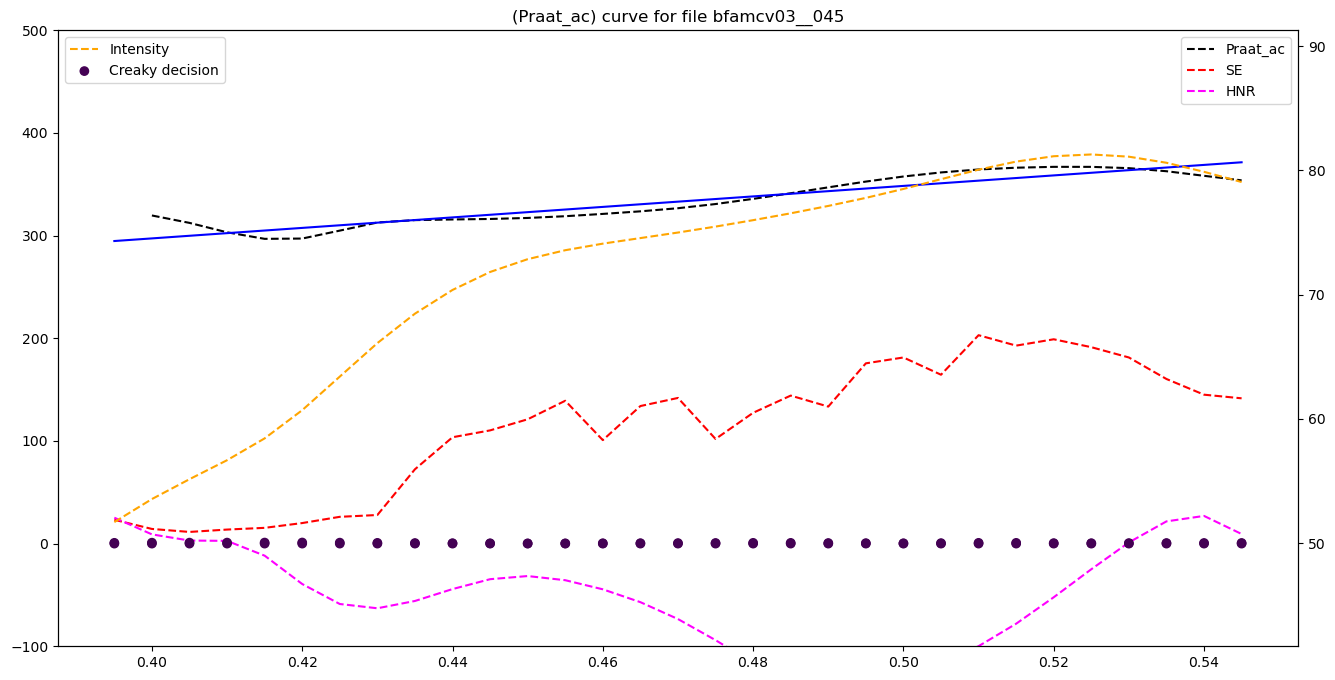

<Figure size 640x480 with 0 Axes>

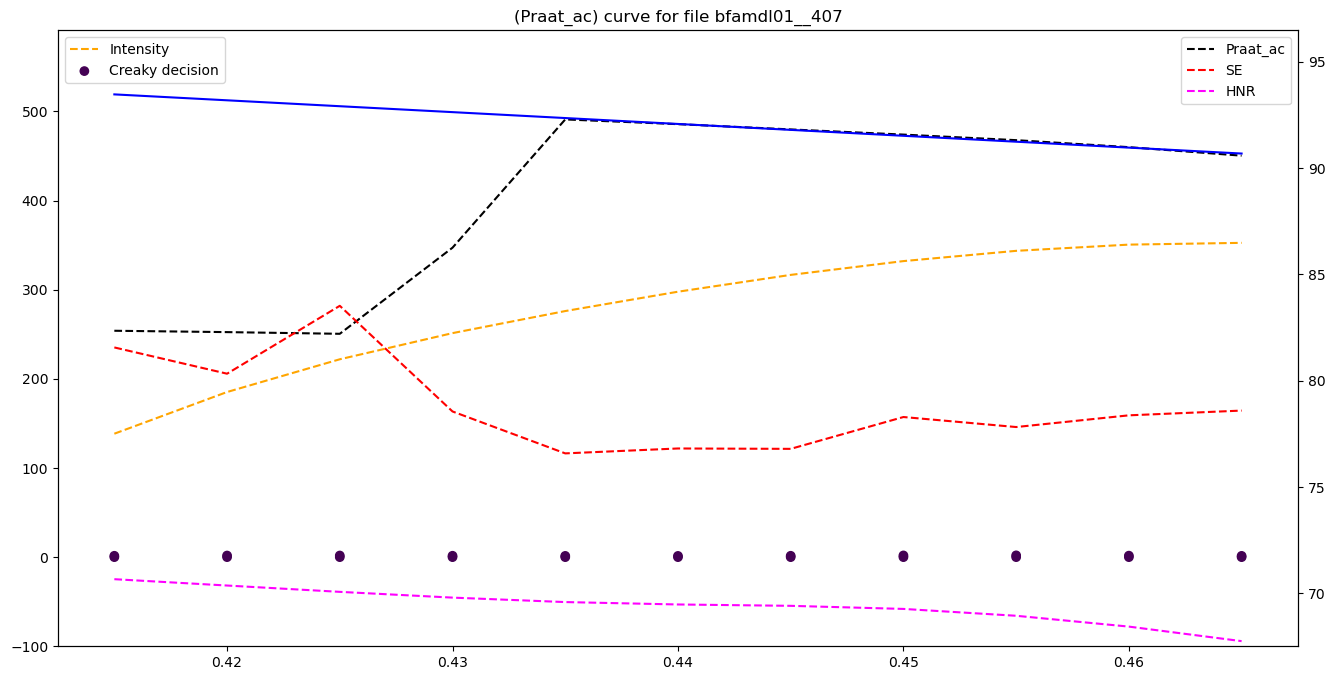

<Figure size 640x480 with 0 Axes>

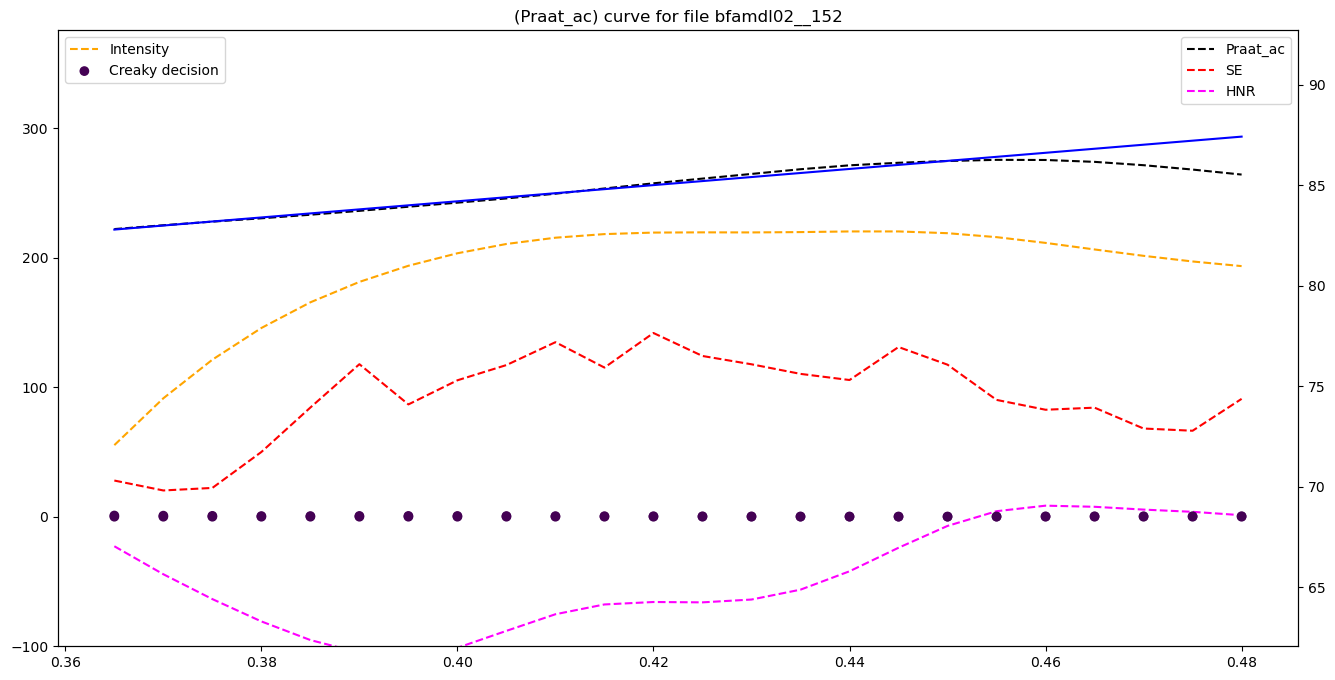

<Figure size 640x480 with 0 Axes>

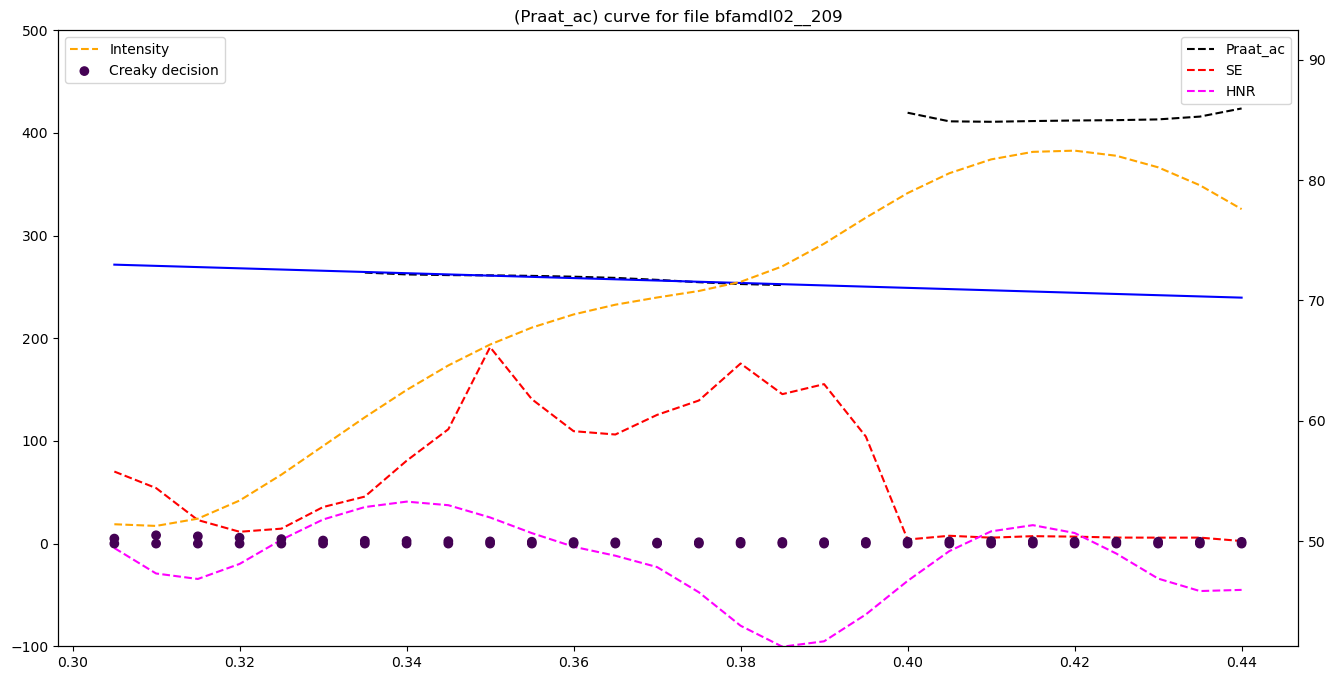

<Figure size 640x480 with 0 Axes>

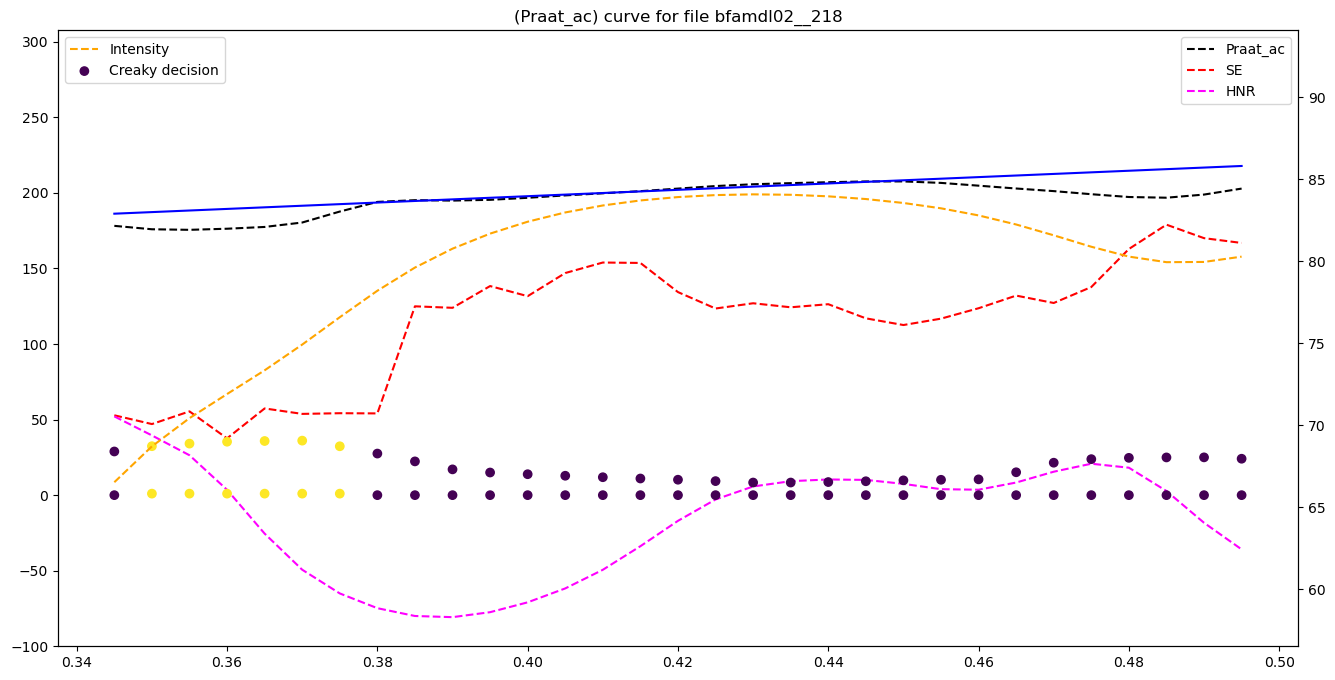

<Figure size 640x480 with 0 Axes>

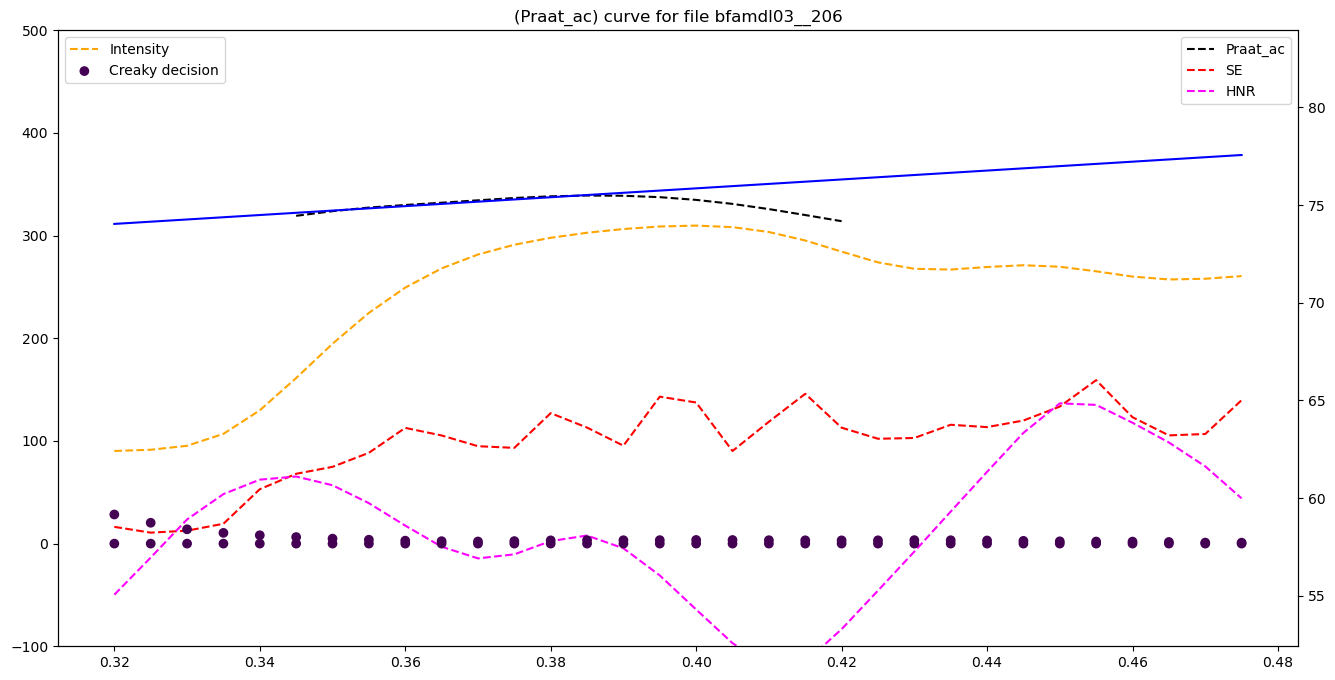

<Figure size 640x480 with 0 Axes>

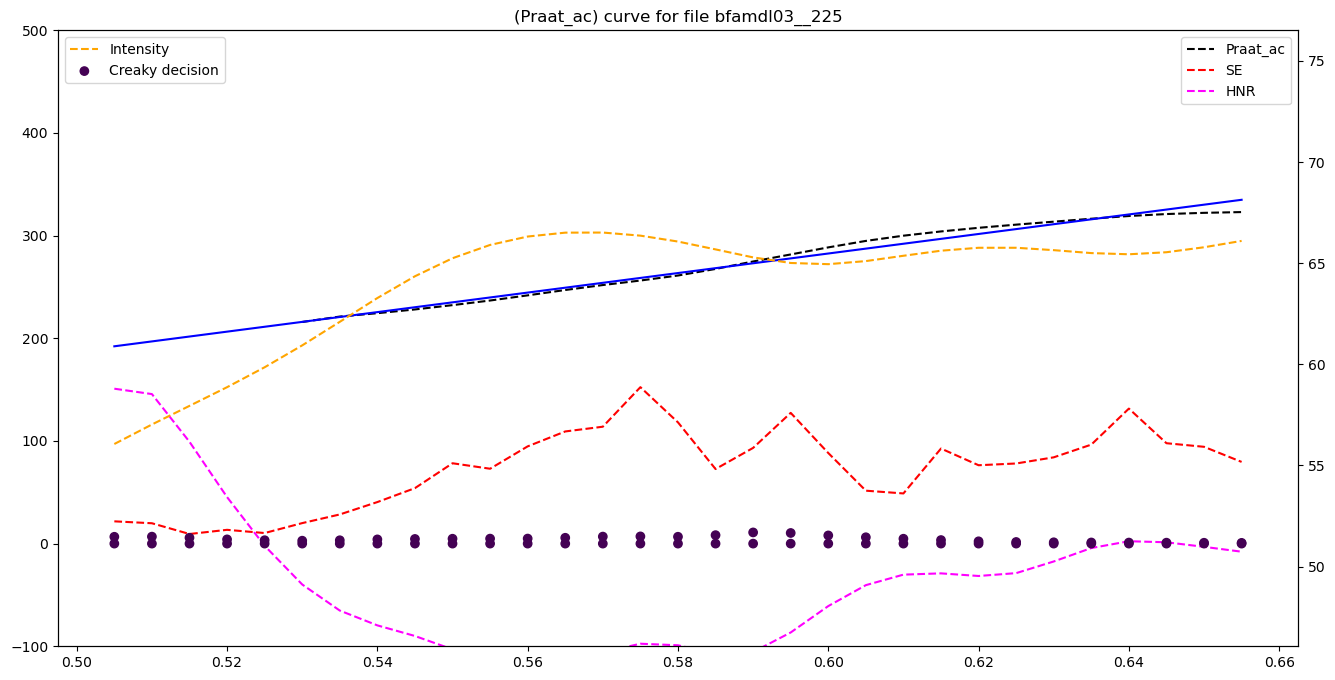

<Figure size 640x480 with 0 Axes>

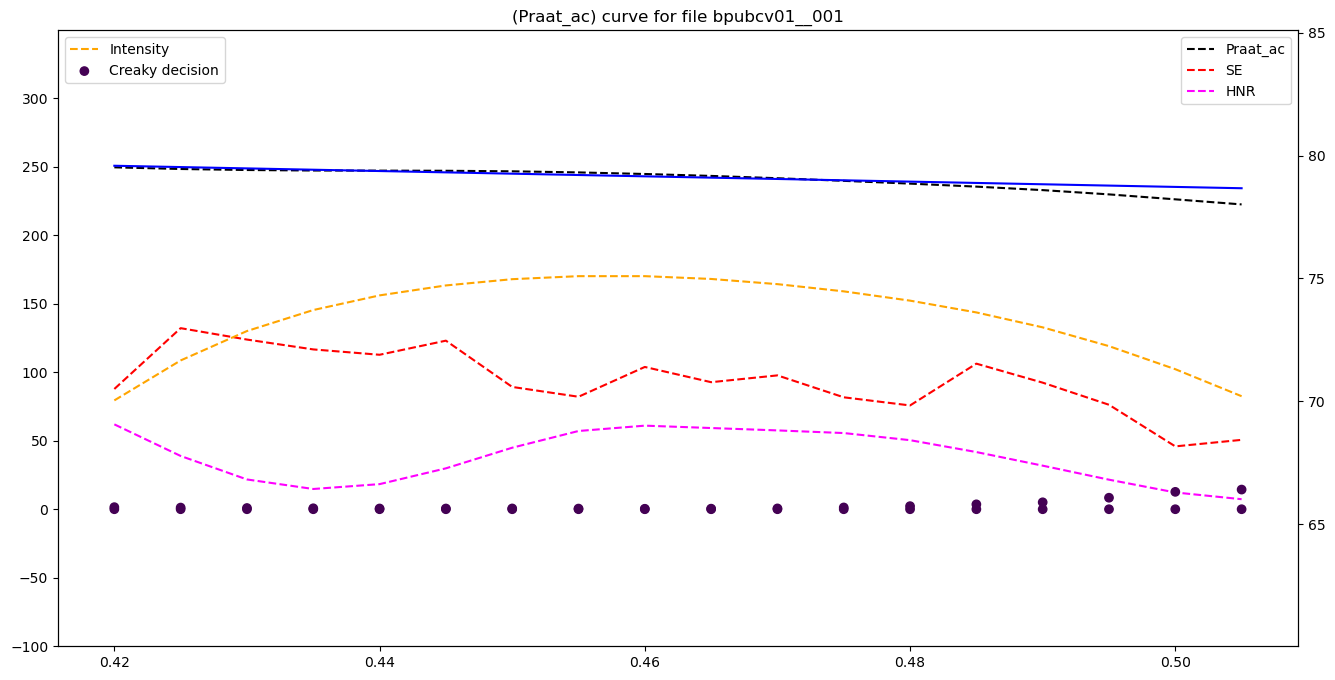

<Figure size 640x480 with 0 Axes>

In [238]:
ALGO = 'praat_ac'

for FILE in initial_outliers['file_name'].unique():

    # We get the data from subset_dict
    data_subset_temp = subset_dict[FILE]

    # We plot the curve
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax2 = ax1.twinx()

    # Set y-axis limits for ax1
    ax1_left_ylim = max(data_subset_temp[ALGO]) + 100
    # If nan, then set to 500
    if np.isnan(ax1_left_ylim):
        ax1_left_ylim = 500
    ax1.set_ylim(-100, ax1_left_ylim)

    # Set y-axis limits for ax2
    intensity_min = min(data_subset_temp['intensity_dB'])
    intensity_max = max(data_subset_temp['intensity_dB'])
    ax2_right_ylim_min = intensity_min - 10
    ax2_right_ylim_max = intensity_max + 10
    ax2.set_ylim(ax2_right_ylim_min, ax2_right_ylim_max)

    # Plot the dashed curves
    algo_plot = ax1.plot(data_subset_temp['timeframe'], data_subset_temp[ALGO], color='black', zorder=1, linestyle='dashed')
    se_plot = ax1.plot(data_subset_temp['timeframe'], data_subset_temp['se']*10, color='red', zorder=1, linestyle='dashed')
    hnr_plot = ax1.plot(data_subset_temp['timeframe'], data_subset_temp['hnr']*10, color='fuchsia', zorder=1, linestyle='dashed')
    intensity_plot = ax2.plot(data_subset_temp['timeframe'], data_subset_temp['intensity_dB'], color='orange', zorder=1, linestyle='dashed')

    # We want to plot the regression line
    slope = data[data['file_name'] == FILE][ALGO + '_slope'].values[0]
    intercept = data[data['file_name'] == FILE][ALGO + '_intercept'].values[0]
    abline_values = [slope * i + intercept for i in data_subset_temp['timeframe'].values]
    ax1.plot(data_subset_temp['timeframe'].values, abline_values, color='blue', zorder=1)

    # Plot creaky decision
    creaky_decision_plot = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['creaky_decision'], c=data_subset_temp['creaky_decision'], zorder=1)

    # Plot the creaky probability * 100 with colours mapped to creaky decision
    creaky_prob = ax1.scatter(data_subset_temp['timeframe'], data_subset_temp['creaky_prob']*100, c=data_subset_temp['creaky_decision'], zorder=1)


    # Set legends
    ax1.legend(algo_plot + se_plot + hnr_plot, [ALGO.capitalize(), 'SE', 'HNR', 'Regression line'], loc='upper right')
    ax2.legend(intensity_plot + [creaky_decision_plot], ['Intensity', 'Creaky decision', 'Creaky probability'], loc='upper left')



    # Set title
    plt.title('({0}) curve for file {1}'.format(ALGO.capitalize(), FILE))
    plt.show()

    # Save figure
    plt.savefig(ALGO + '_curves/{0}.png'.format(FILE), dpi=300)


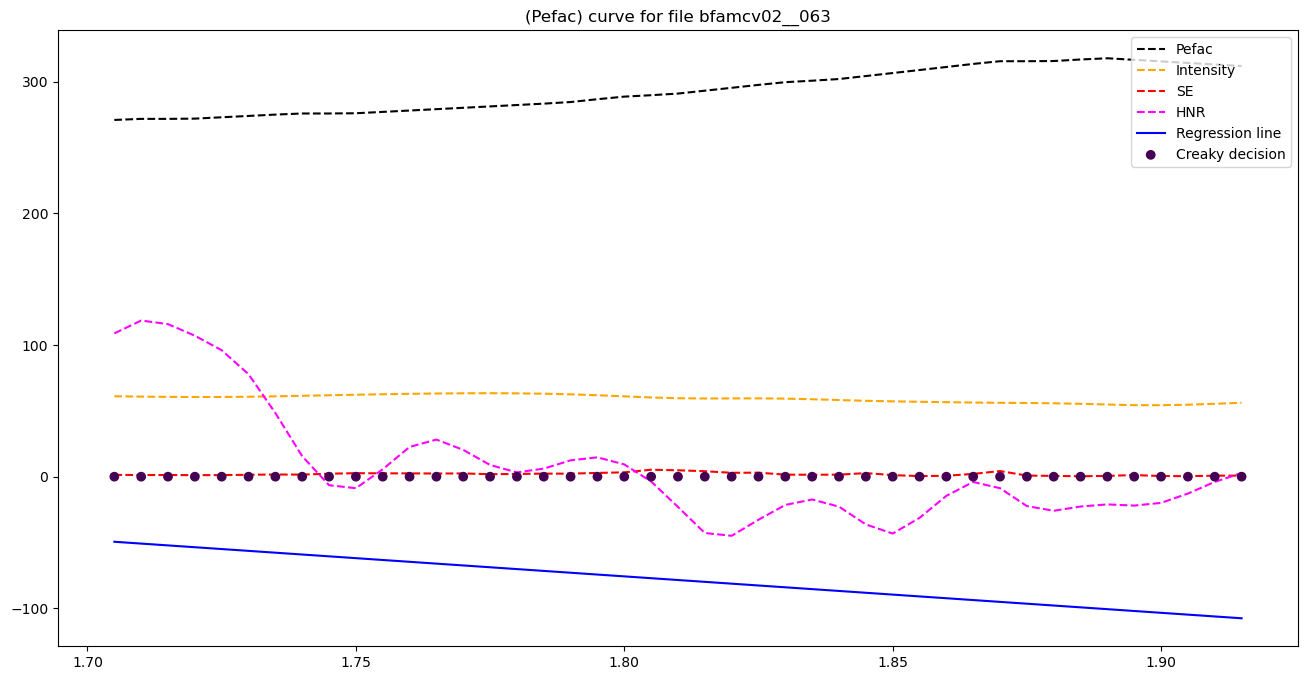

<Figure size 640x480 with 0 Axes>

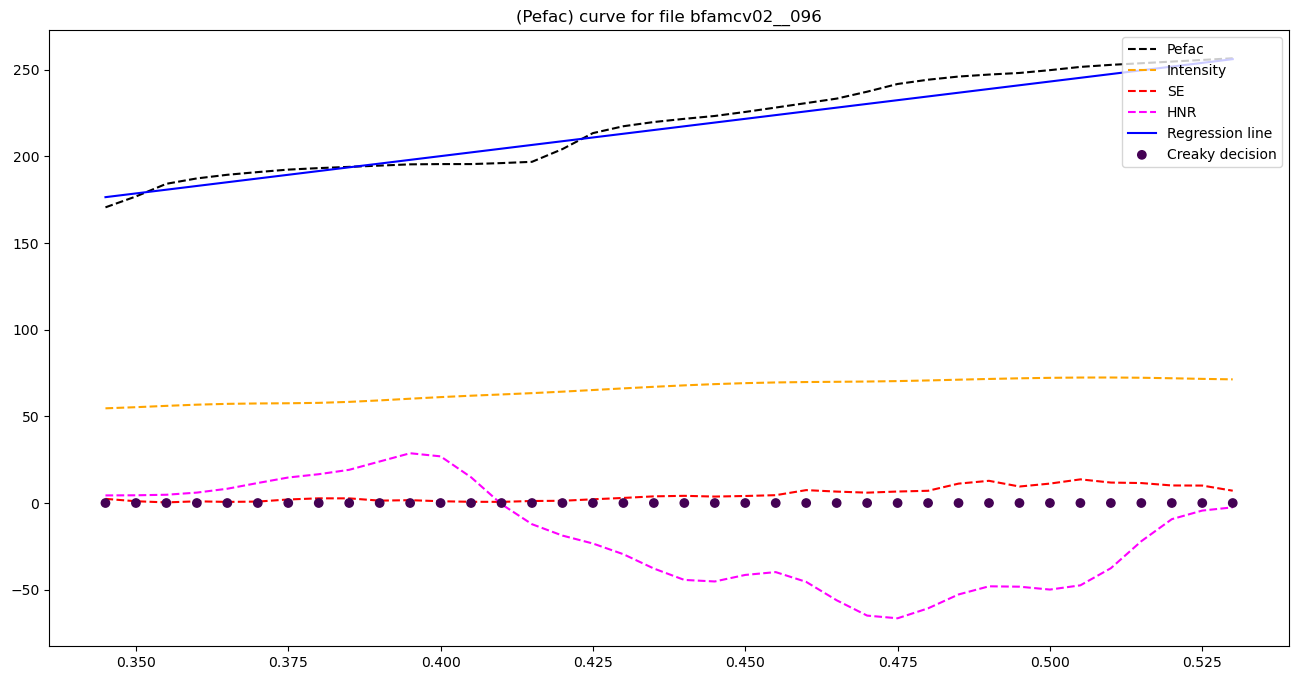

<Figure size 640x480 with 0 Axes>

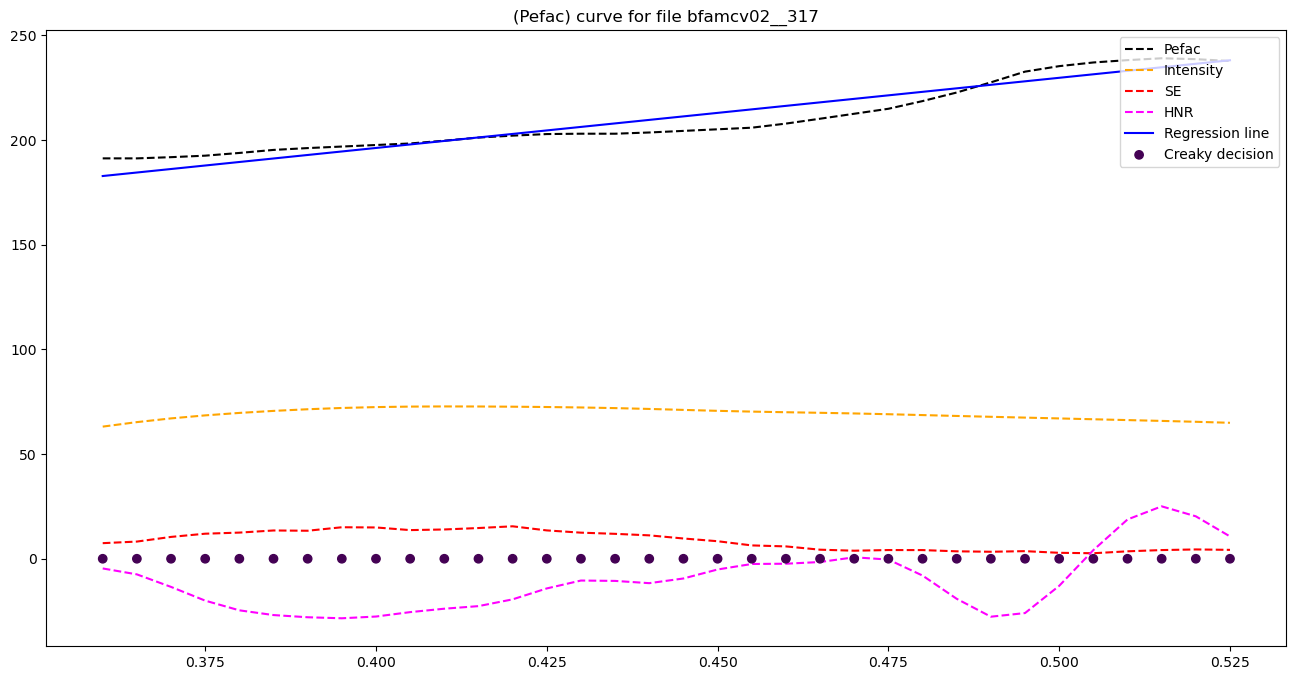

<Figure size 640x480 with 0 Axes>

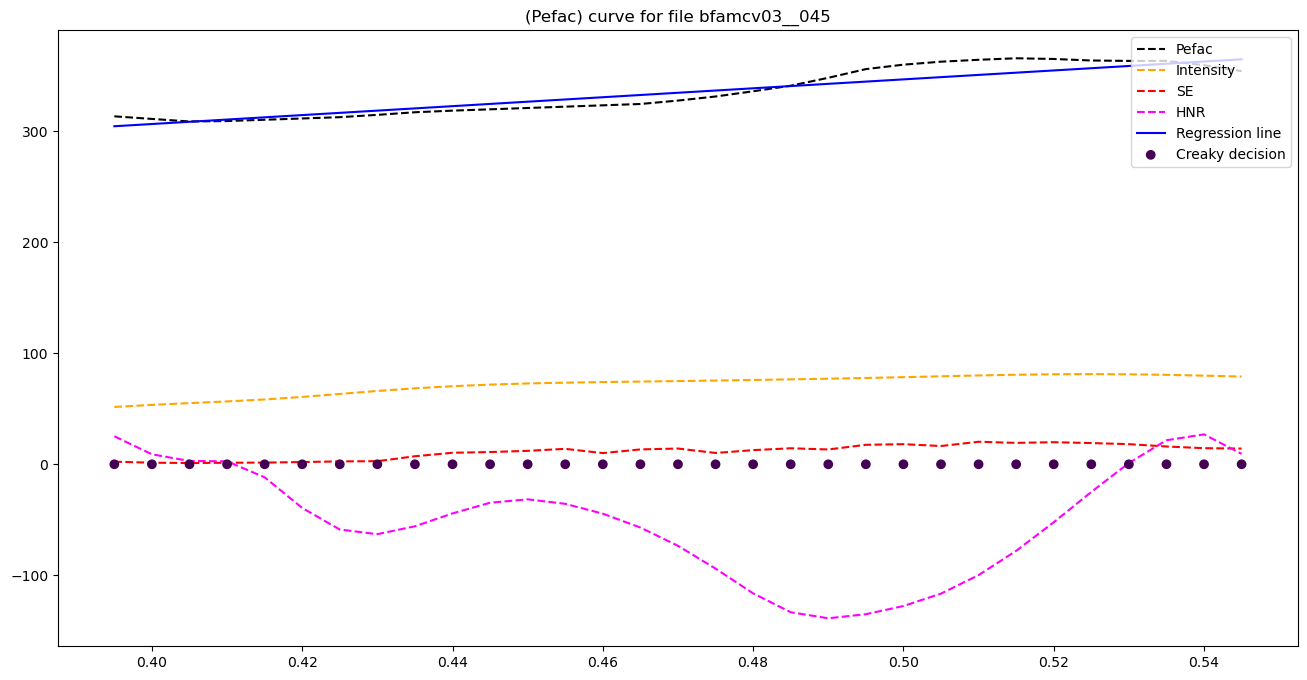

<Figure size 640x480 with 0 Axes>

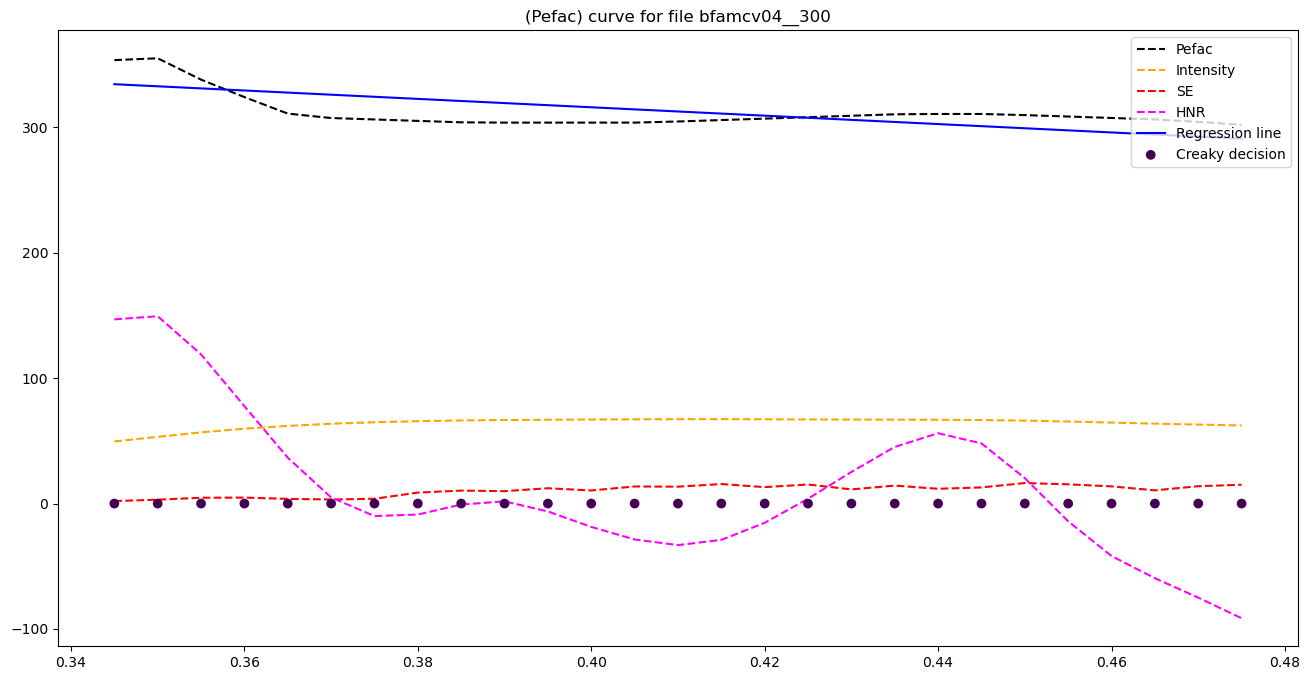

<Figure size 640x480 with 0 Axes>

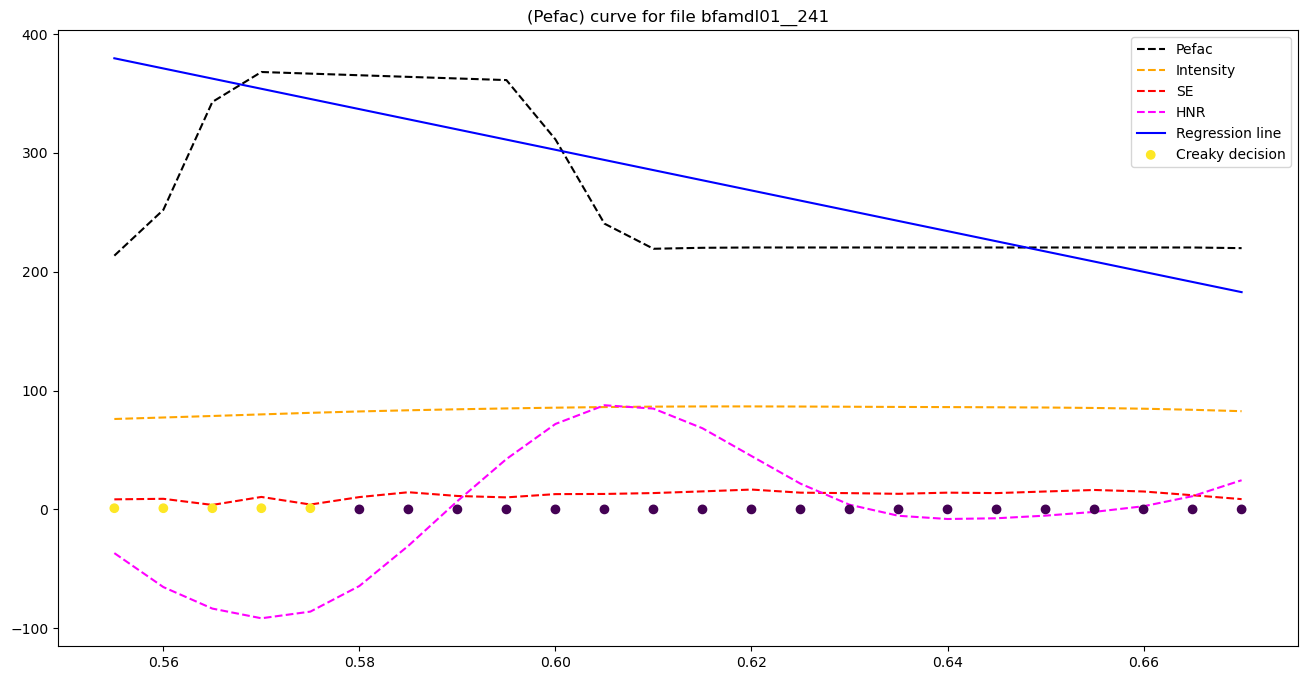

<Figure size 640x480 with 0 Axes>

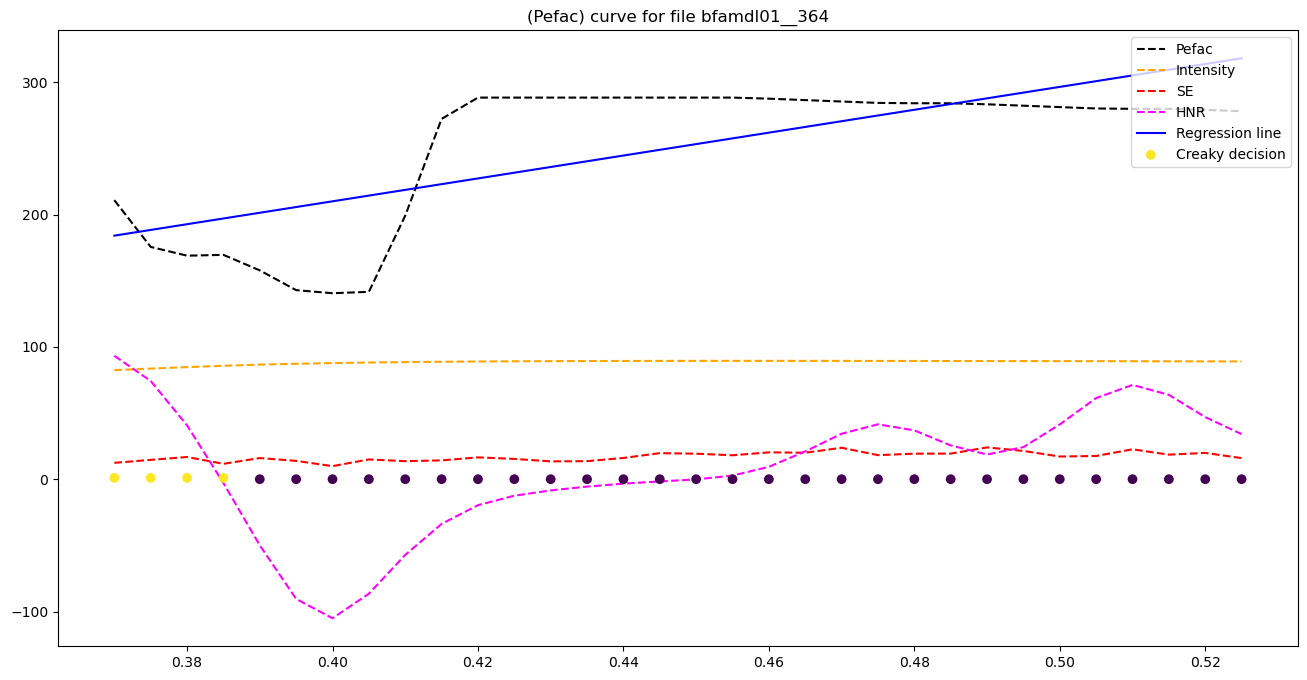

<Figure size 640x480 with 0 Axes>

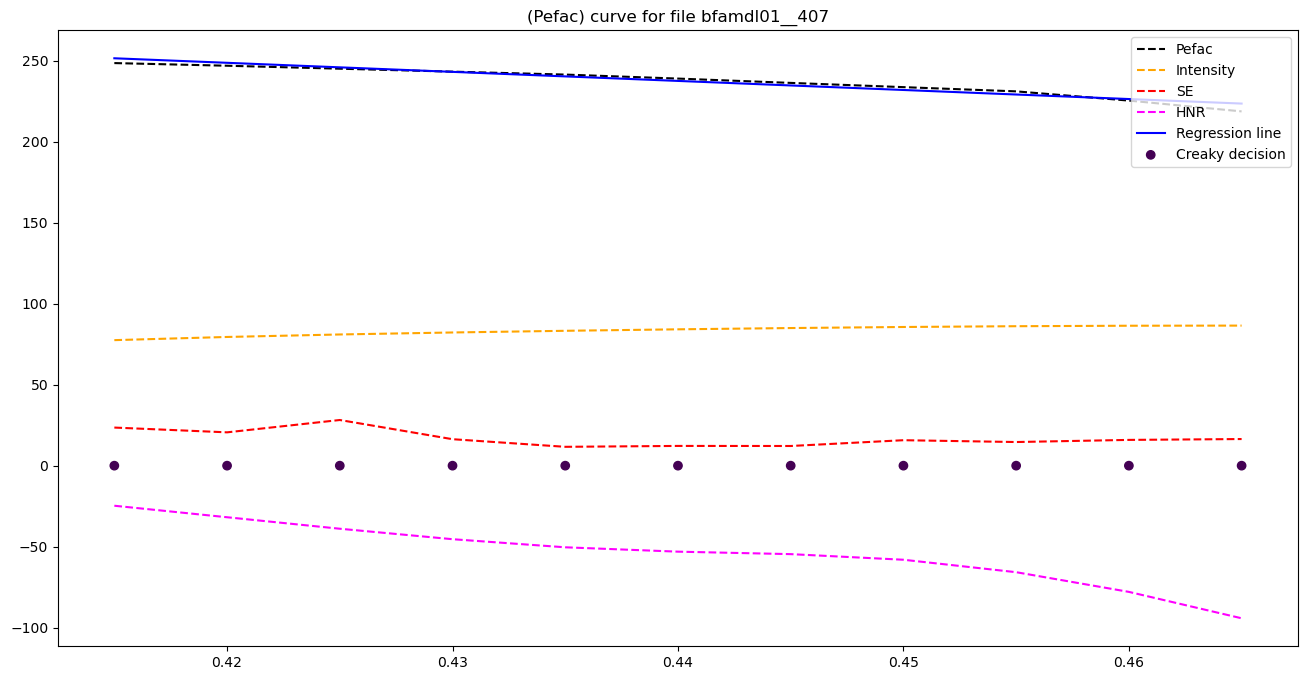

<Figure size 640x480 with 0 Axes>

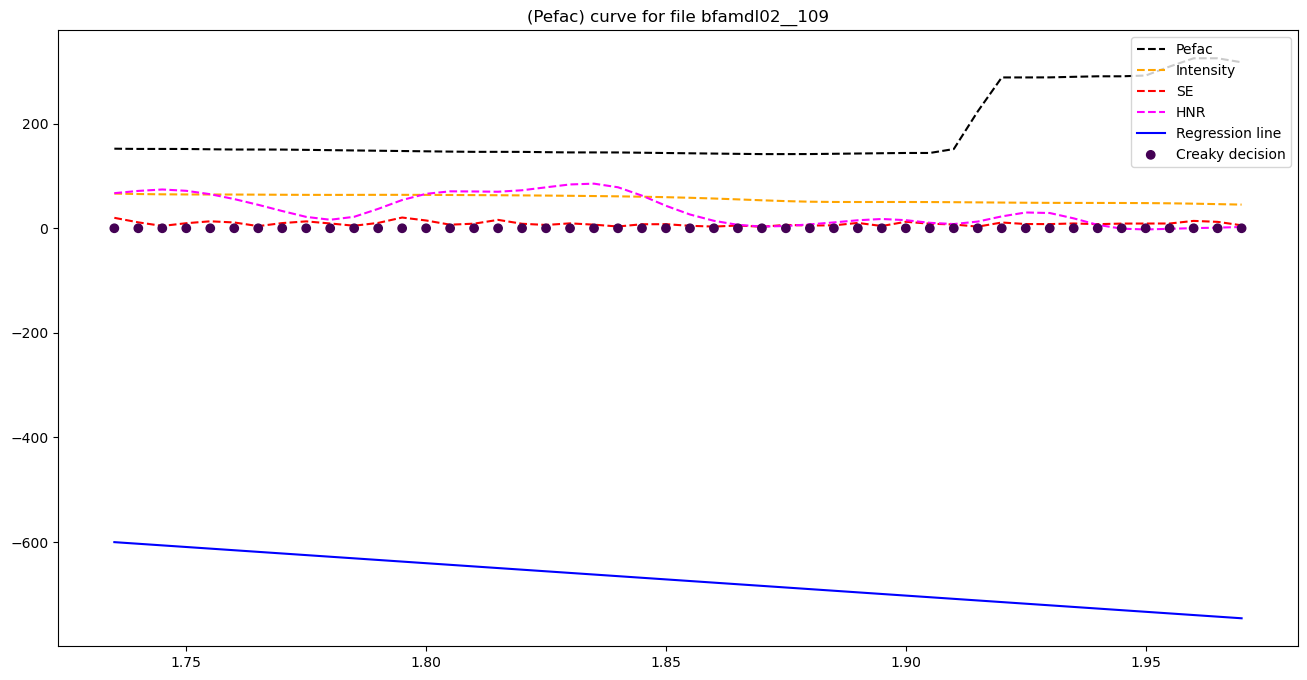

<Figure size 640x480 with 0 Axes>

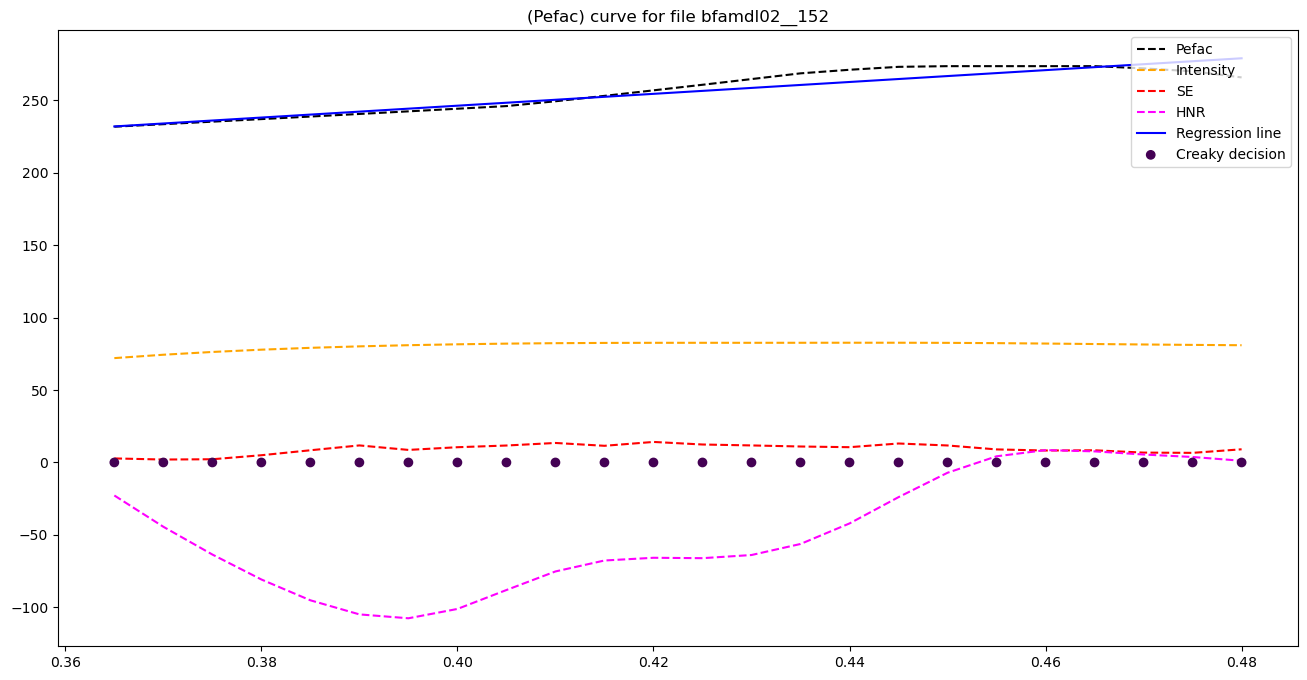

<Figure size 640x480 with 0 Axes>

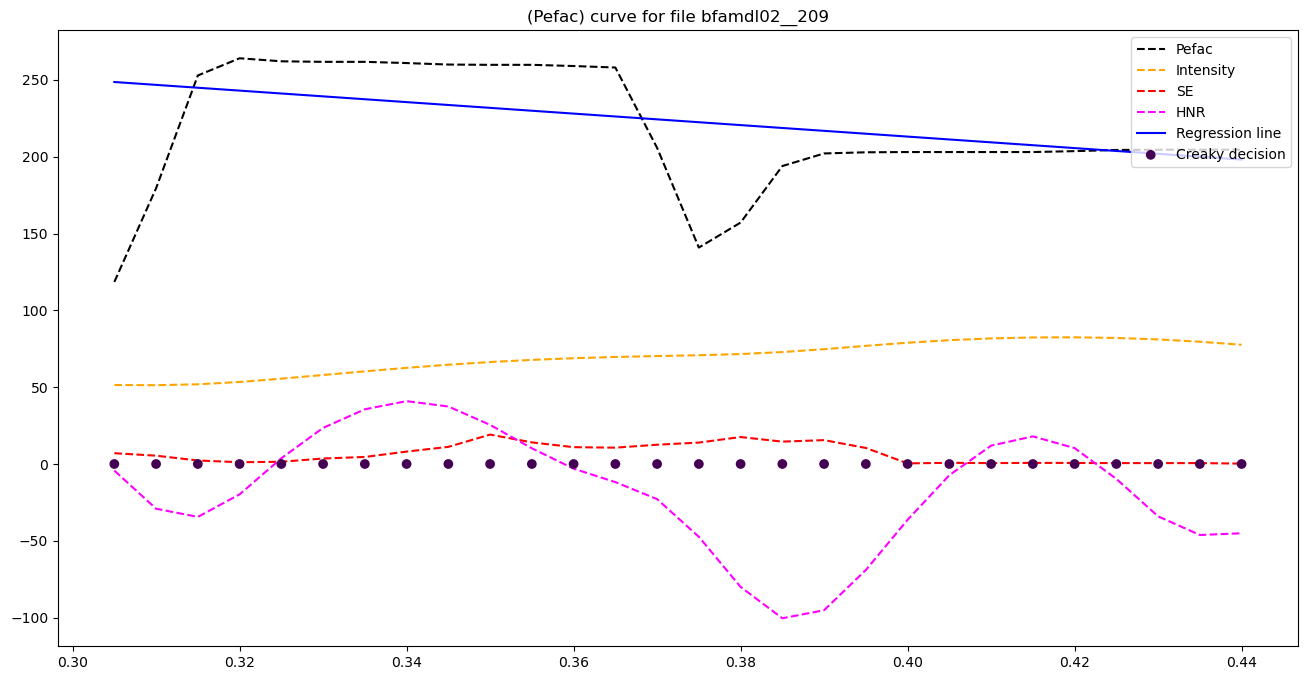

<Figure size 640x480 with 0 Axes>

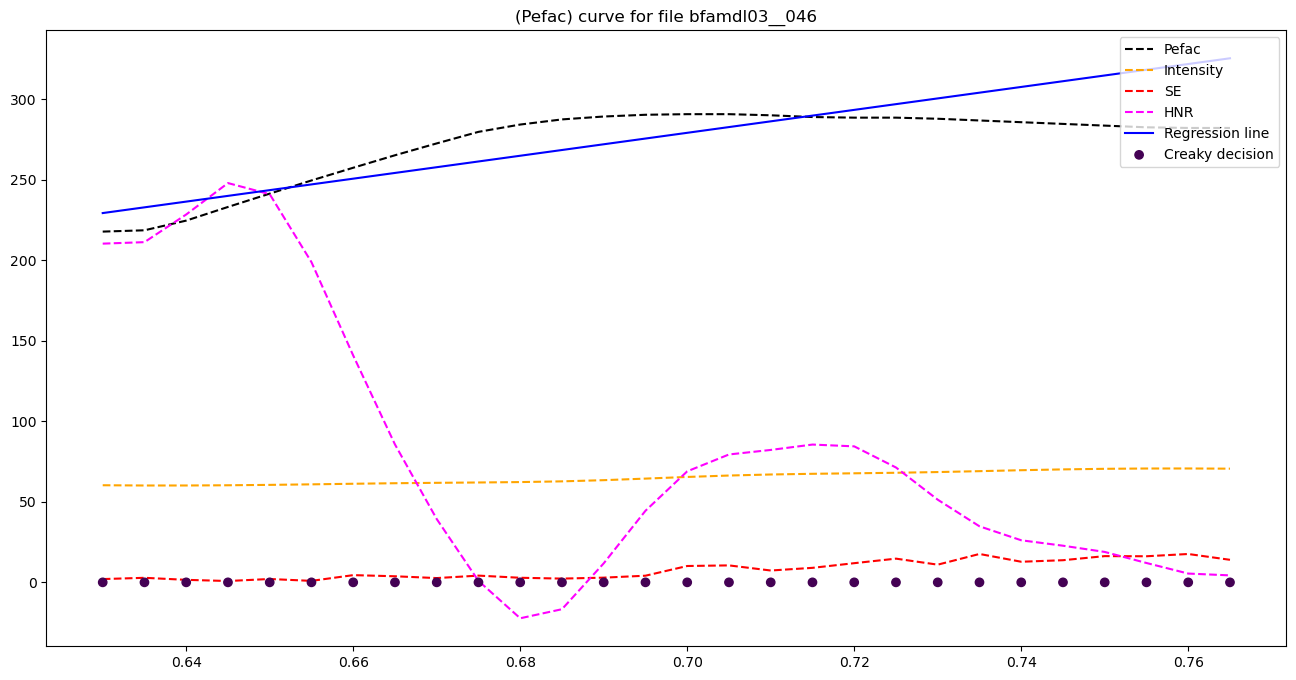

<Figure size 640x480 with 0 Axes>

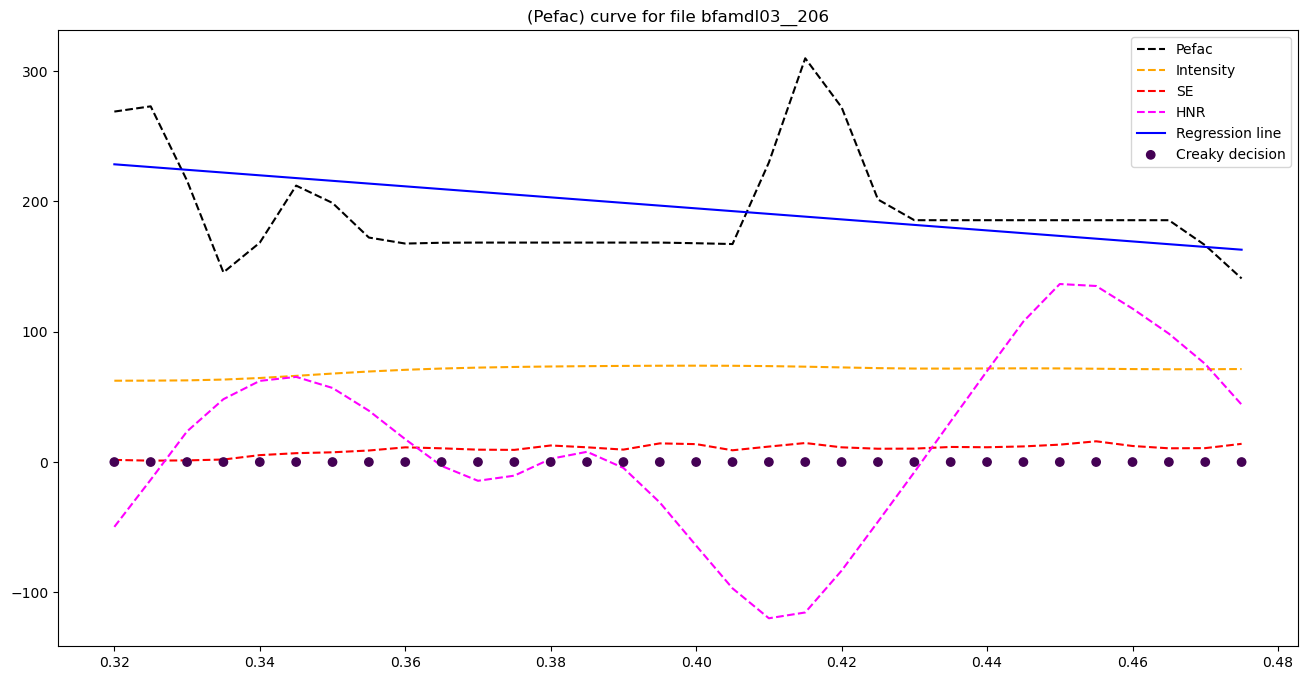

<Figure size 640x480 with 0 Axes>

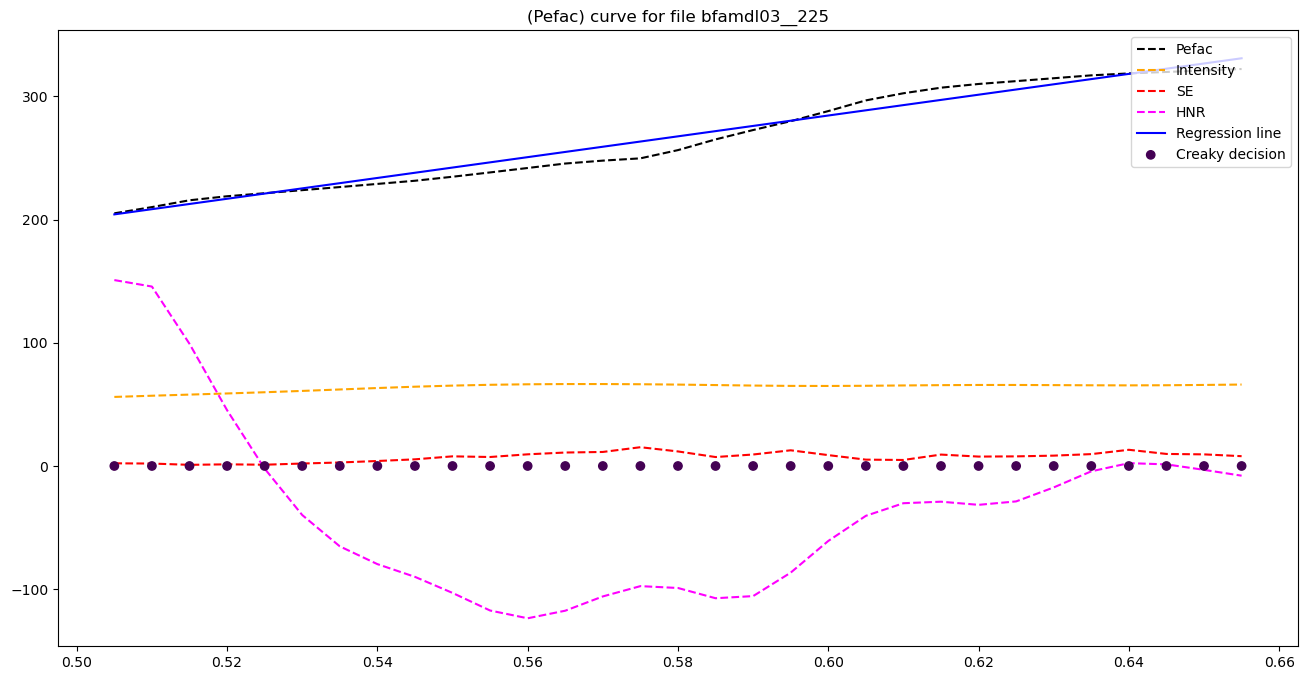

<Figure size 640x480 with 0 Axes>

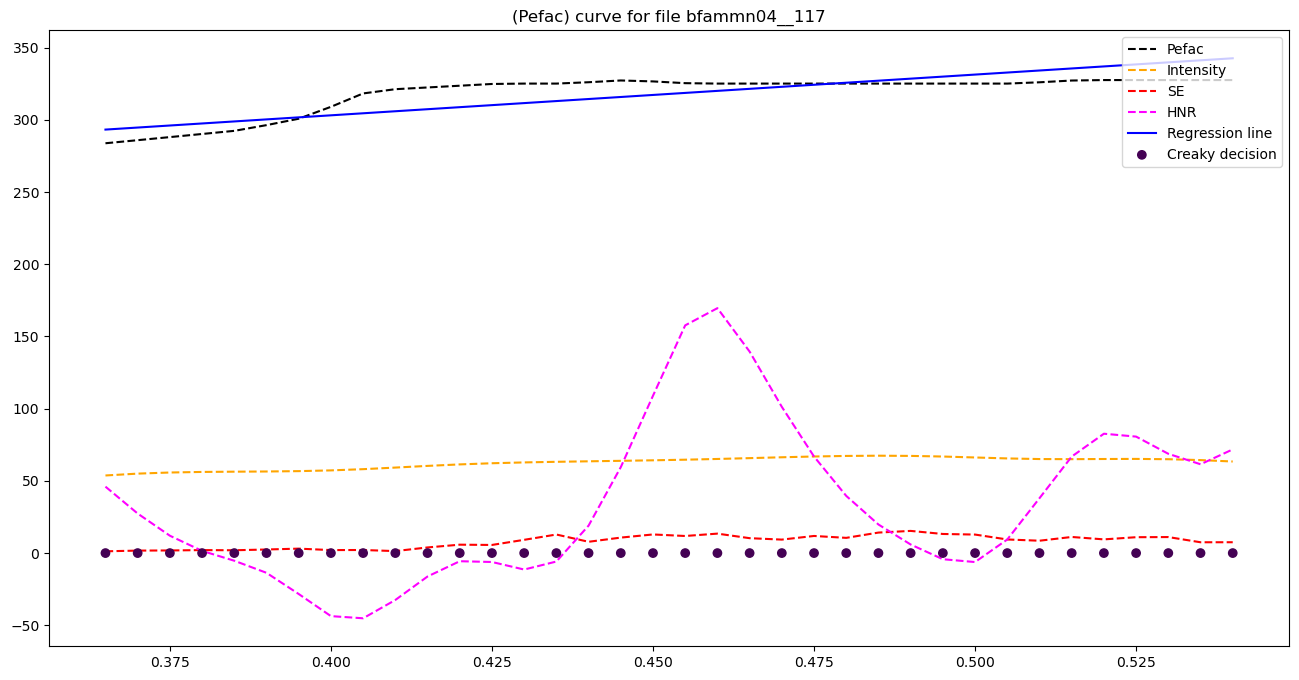

<Figure size 640x480 with 0 Axes>

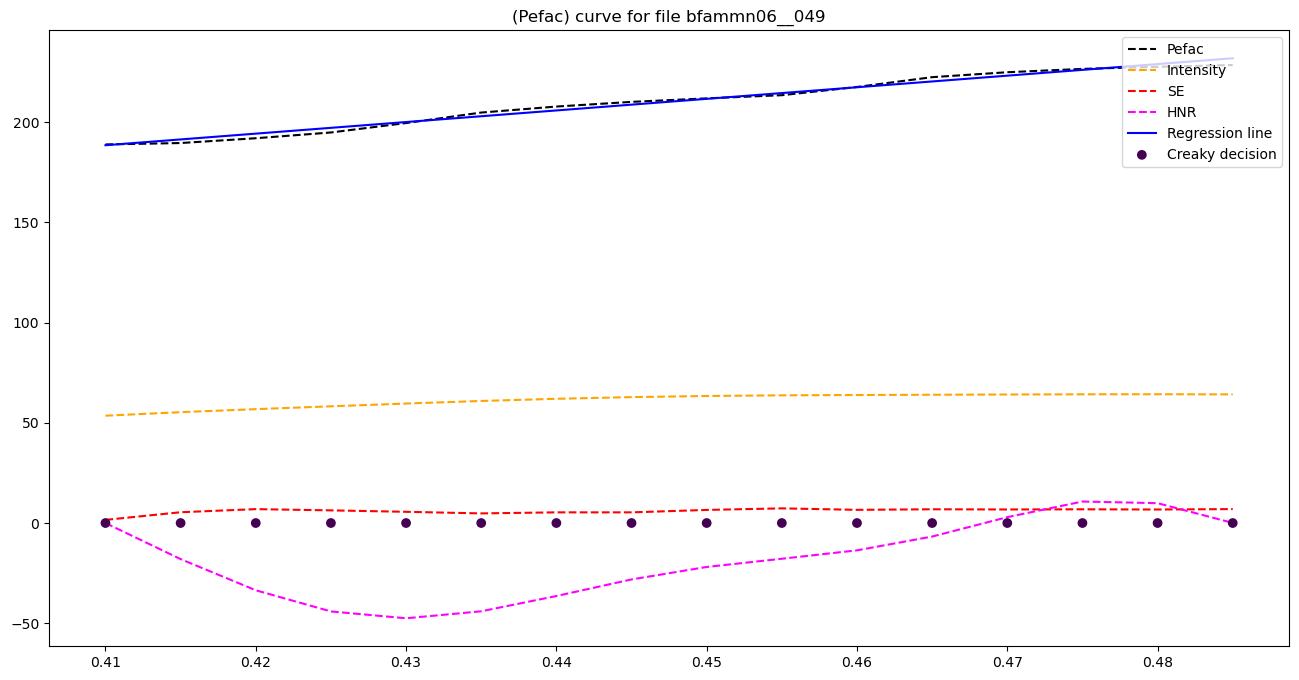

<Figure size 640x480 with 0 Axes>

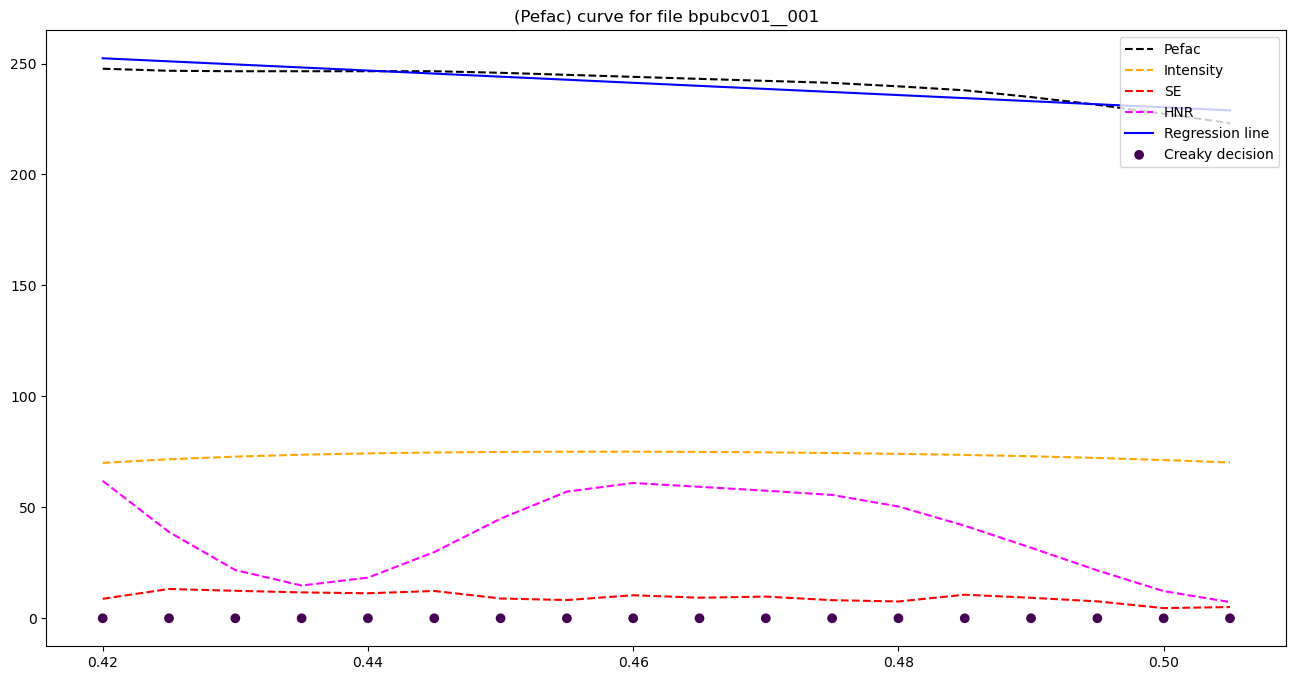

<Figure size 640x480 with 0 Axes>

In [142]:
# We plot intensity and se curves at the same plot with different colours

ALGO = 'pefac'

for FILE in initial_outliers['file_name'].unique():

    # We get the data from subset_dict
    data_subset_temp = subset_dict[FILE]

    # We plot the curve
    plt.figure(figsize=(16, 8))


    # We must use two different y axis and limits: one for pefac and other for intensity and se
    
 

    # Plot the dashed curves
    plt.plot(data_subset_temp['timeframe'], data_subset_temp[ALGO], color='black', zorder=1, linestyle='dashed')
    plt.plot(data_subset_temp['timeframe'], data_subset_temp['intensity_dB'], color='orange', zorder=1, linestyle='dashed')
    plt.plot(data_subset_temp['timeframe'], data_subset_temp['se'], color='red', zorder=1, linestyle='dashed')
    # HNR values for aperidicity
    plt.plot(data_subset_temp['timeframe'], data_subset_temp['hnr']*10, color='fuchsia', zorder=1, linestyle='dashed')

    # We want to plot the regression line
    # We do this accordind to the fit_line_ransac function
    # We need to get the slope and intercept
    # Get slope and intercept from the data dataframe
    slope = data[data['file_name'] == FILE][ALGO + '_slope'].values[0]
    intercept = data[data['file_name'] == FILE][ALGO + '_intercept'].values[0]
    abline_values = [slope * i + intercept for i in data_subset_temp['timeframe'].values]
    plt.plot(data_subset_temp['timeframe'].values, abline_values, color='blue', zorder=1)


    # Plot creaky decision
    plt.scatter(data_subset_temp['timeframe'], data_subset_temp['creaky_decision'], c=data_subset_temp['creaky_decision'], zorder=1)
    #plt.plot(data_subset_temp['timeframe'], data_subset_temp['creaky_decision'], color='blue', zorder=1)

    # Set legends
    plt.legend([ALGO.capitalize(), 'Intensity', 'SE', 'HNR', 'Regression line', 'Creaky decision'], loc='upper right')

    # Set title
    plt.title('({0}) curve for file {1}'.format(ALGO.capitalize(), FILE))
    plt.show()

    # Save figure
    plt.savefig(ALGO + '_curves/{0}.png'.format(FILE), dpi=300)

# MODELING

In [108]:
# Get initial column names
initial.columns

Index(['id', 'file', 'utt', 'speaker', 'N_UT', 'T_UT', 'dm_text',
       'utterance_text', 'tag', 'kept', 'Exclusion_reason', 'stanza',
       'pattern', 'notes', 'channel', 'In', 'Insd', 'Inmax', 'Inmin', 'Intmax',
       'Intmin', 'InmaxTa', 'InminTa', 'f0', 'f0sd', 'f0max', 'f0min',
       'f0tmax', 'f0tmin', 'f0exc', 'f0slo', 'f0maxTa', 'f0minTa', 'if0sit',
       'if0stf', 'N_Sil', 'Dur', 'Dm_sil', 'Zm_sil', 'Z_ut', 'file_name',
       'mean_se', 'bana_slope', 'bana_intercept', 'pefac_slope',
       'pefac_intercept', 'praat_ac_slope', 'praat_ac_intercept', 'pyin_slope',
       'pyin_intercept', 'srh_slope', 'srh_intercept'],
      dtype='object')

In [109]:
# We use the data to build a LDA model that classifies the units into CNT, INP and EXP
# We create a new dataframe with only the columns we need
X = initial[['In', 
             'Inmax', 
             'Inmin',
             'f0', 
             'f0sd', 
             'Z_ut',
             'srh_slope',
             'srh_intercept',
             'mean_se']]

y = initial['tag']

In [110]:
# We use the data to build a LDA model that classifies the units into CNT, INP and EXP
# We create a new dataframe with only the columns we need
X = initial[['In', 
             'Insd', 
             'Inmax', 
             'Inmin', 
             'Intmax',
             'Intmin', 
             'InmaxTa', 
             'InminTa', 
             'f0', 
             'f0sd', 
             'f0max', 
             'f0min',
             'f0tmax', 
             'f0tmin', 
             'f0exc', 
             'f0slo', 
             'f0maxTa', 
             'f0minTa', 
             'if0sit',
             'if0stf', 
             'Z_ut',
             'srh_slope',
             'srh_intercept',
             'mean_se']]

y = initial['tag']

In [112]:
# We deal with missing values
X = X.fillna(X.mean())


# Import LabelEncoder
from sklearn import preprocessing
# We encode the target variable
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# Check the classes
le.classes_

array(['CNT', 'EXP', 'INP'], dtype=object)

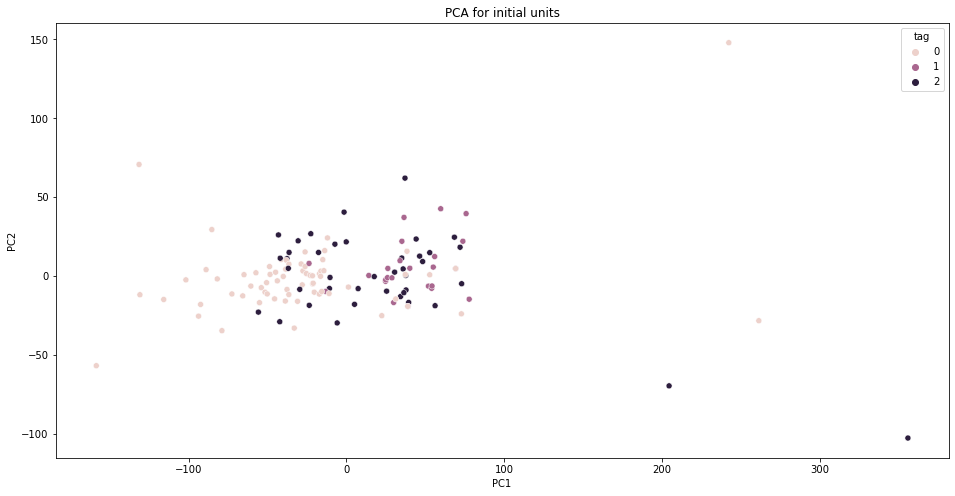

In [114]:
# We perform a PCA to reduce the dimensionality of the data
# Import PCA
from sklearn.decomposition import PCA

# We create a PCA object
pca = PCA(n_components=2)

# We fit the PCA object to our data
pca.fit(X)

# We transform our data
X_pca = pca.transform(X)

# We create a dataframe with the PCA data
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# We add the tag column to the dataframe
X_pca['tag'] = y

# We plot the data
# Set figure size
plt.figure(figsize=(16, 8))

# Set ylim

sns.scatterplot(x='PC1', y='PC2', data=X_pca, hue='tag', zorder=1)

# Set title
plt.title('PCA for initial units')
plt.show()

In [ ]:
# Import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# We create a LDA model
lda = LinearDiscriminantAnalysis()

# We do a cross validation of the model
from sklearn.model_selection import cross_val_score

# We get the scores using balanced accuracy
scores = cross_val_score(lda, X, y, cv=3, scoring='balanced_accuracy')

# We print the scores
print(scores)

# We print the mean of the scores
print(scores.mean())



[0.37991718 0.46753066 0.56980519]
0.4724176789394181


In [ ]:
# We print the confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(lda, X, y, cv=10)

conf_mat = confusion_matrix(y, y_pred)

print(conf_mat)

# We print the classification report
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

# We print the accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y, y_pred))

[[53  4 11]
 [17  2  5]
 [22  4 15]]
              precision    recall  f1-score   support

           0       0.58      0.78      0.66        68
           1       0.20      0.08      0.12        24
           2       0.48      0.37      0.42        41

    accuracy                           0.53       133
   macro avg       0.42      0.41      0.40       133
weighted avg       0.48      0.53      0.49       133

0.5263157894736842
